In [33]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [35]:
import os
import pandas as pd 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        globals()[filename.split('.')[0]] = pd.read_csv(dirname+'/'+filename)
        
        print(filename)

customeraccount.csv
sample_submission.csv
transaction_header.csv
genel_kategoriler.csv
customer.csv
train.csv
test.csv
product_groups.csv
transaction_sale.csv


In [36]:
import numpy as np 
import torch
import optuna
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
import datetime
from datetime import date
from collections import Counter
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score,mean_squared_error
from itertools import combinations
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor


pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=25
cm = sns.light_palette("red", as_cmap=True)

def null_rate(df):
    return (df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'}).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook
tqdm.pandas(desc="my bar!")



import warnings
warnings.filterwarnings('ignore')

def calculate_optimum_threshold(y_true, y_pred_labels):
    max_thresh = 0.3
    max_score = 0
    for thresh in range(30, 60, 2):
        thresh = thresh / 100
        y_pred = (y_pred_labels > thresh).astype('int')
        score = f1_score(y_true, y_pred)
        if score >= max_score:
            max_score = score
            max_thresh = thresh
        if y_pred.sum()/y_pred.shape[0] < 0.005:
            continue
    print(f"Optimum threshold: {max_thresh}, Score: {max_score}")
    return max_thresh, max_score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels
    Parameters
    ----------
    y_true (numpy.ndarray of shape (n_samples)): Ground truth labels
    y_pred (numpy.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    scores (dict): Dictionary of calculated scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
#         'accuracy': accuracy_score(y_true, y_pred_labels),
#         'roc_auc': roc_auc_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred_labels),
#         'recall': recall_score(y_true, y_pred_labels),
        'f1': f1_score(y_true, y_pred_labels),
#         'pos_rate': f"{y_pred_labels.sum()}/{y_pred_labels.shape[0]}"
    }

    return scores

def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold
    Parameters
    ----------
    probabilities (np.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    labels (numpy.ndarray of shape (n_samples)): Labels
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels

# Data Preview

### 1-customerAccount

In [37]:
customeraccount=customeraccount.astype({'individualnumber':'object','cardnumber':'object'})
customeraccount.info()
customeraccount.groupby('individualnumber')['cardnumber'].count().to_frame().sort_values('cardnumber',ascending=False)[:50].style.background_gradient(cmap=cm)
print(f'customeraccount null rate.')
null_rate(customeraccount)
print(f' ')
customeraccount.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35159 entries, 0 to 35158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   individualnumber  35159 non-null  object
 1   cardnumber        35159 non-null  object
dtypes: object(2)
memory usage: 549.5+ KB


,cardnumber
individualnumber,
96035559,49
13936527,25
98338349,21
7923458,17
10817264,17
92455160,16
92472145,16
89086894,15
42273372,15


customeraccount null rate.


,null_rate
individualnumber,0.000000
cardnumber,0.000000


,individualnumber,cardnumber
count,35159,35159
unique,28593,35159
top,96035559,7287134635560315
freq,49,1


### 2-customer

In [38]:
customer=customer.astype({'individualnumber':'object','city_code':'object'})
customer.info()
print(f'\n\n')
null_rate(customer)
print(f'\n\n')
customer.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28593 entries, 0 to 28592
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  28593 non-null  object 
 1   gender            28588 non-null  object 
 2   city_code         21886 non-null  object 
 3   dateofbirth       28578 non-null  float64
dtypes: float64(1), object(3)
memory usage: 893.7+ KB





,null_rate
city_code,0.234568
dateofbirth,0.000525
gender,0.000175
individualnumber,0.000000


,individualnumber,gender,city_code,dateofbirth
count,28593.0,28588,21886.0,28578.000000
unique,28593.0,2,82.0,NaN
top,94212124.0,E,34.0,NaN
freq,1.0,15192,4600.0,NaN
mean,NaN,NaN,NaN,1979.989013
std,NaN,NaN,NaN,13.892713
min,NaN,NaN,NaN,1920.000000
25%,NaN,NaN,NaN,1971.000000
50%,NaN,NaN,NaN,1982.000000
75%,NaN,NaN,NaN,1991.000000


### 3-train

In [39]:
train=train.astype({'individualnumber':'object','category_number':'object','response':'float'})
train.info()
null_rate(train)
print(f'\n\n')
customeraccount.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13115 entries, 0 to 13114
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13115 non-null  object 
 1   category_number   13115 non-null  object 
 2   hakkedis_amt      13115 non-null  float64
 3   odul_amt          13115 non-null  float64
 4   response          13115 non-null  float64
dtypes: float64(3), object(2)
memory usage: 512.4+ KB


,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000
response,0.000000


,individualnumber,cardnumber
count,35159,35159
unique,28593,35159
top,96035559,7287134635560315
freq,49,1


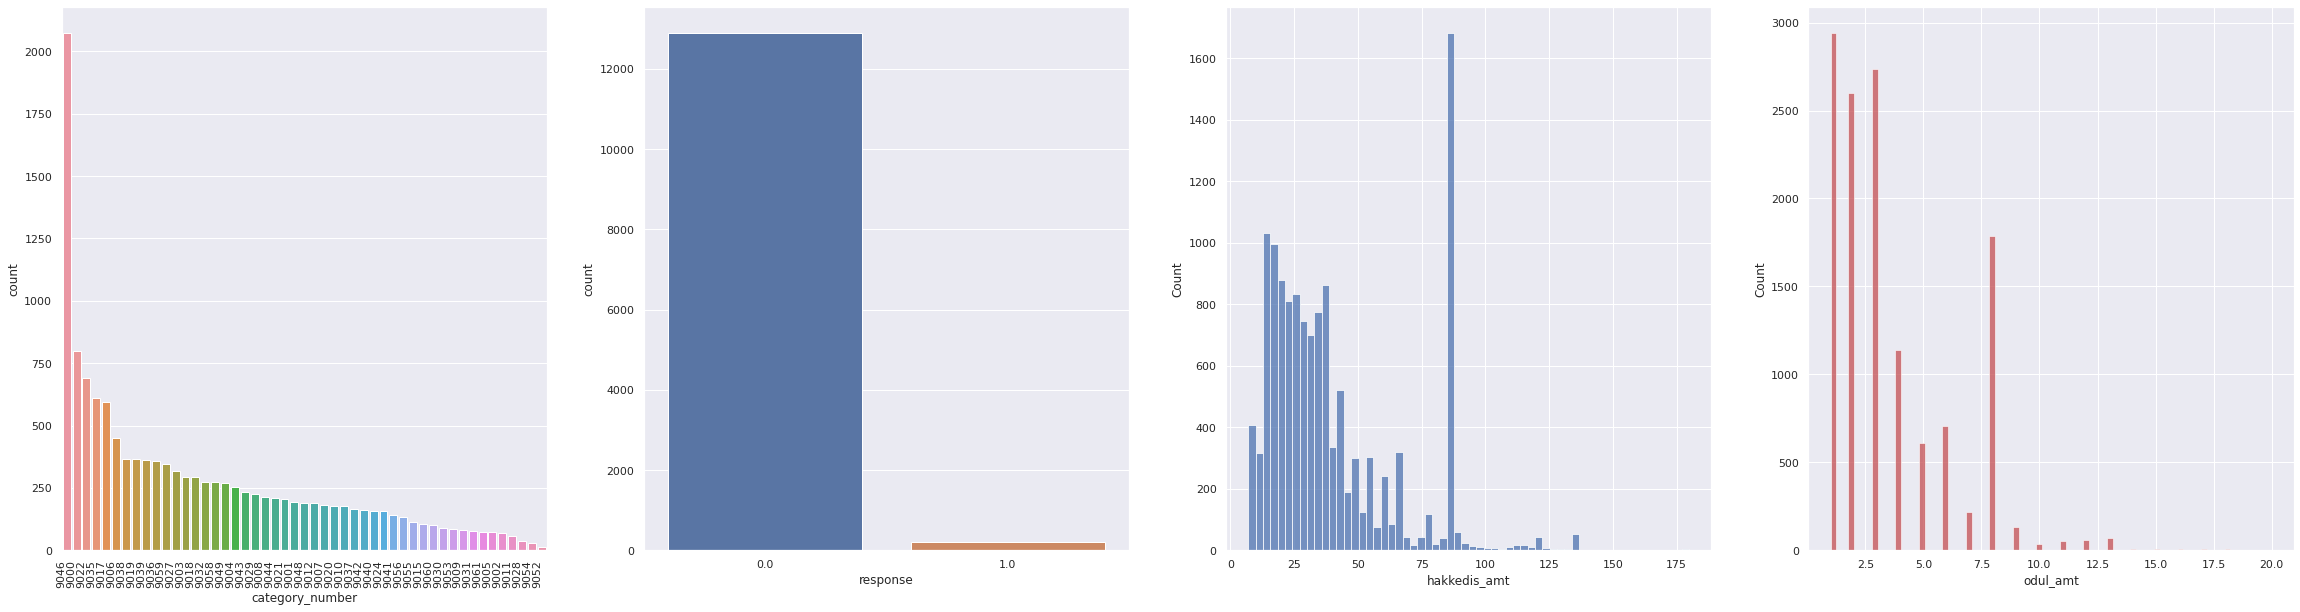

In [40]:
f,ax=plt.subplots(1,4,figsize=[40,10])
sns.countplot(train.category_number,order=train.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.countplot(train.response,ax=ax[1]);
sns.histplot(train.hakkedis_amt,ax=ax[2]);
sns.histplot(train.odul_amt,ax=ax[3],color='r');

### 3-test

In [41]:
test=test.astype({'individualnumber':'object','category_number':'object'})
test.info()
print(f'\n\n')
null_rate(test)
print(f'\n\n')
test.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13236 non-null  object 
 1   category_number   13236 non-null  object 
 2   hakkedis_amt      13236 non-null  float64
 3   odul_amt          13236 non-null  float64
dtypes: float64(2), object(2)
memory usage: 413.8+ KB





,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000


,individualnumber,category_number,hakkedis_amt,odul_amt
count,13236.0,13236.0,13236.000000,13236.000000
unique,13236.0,49.0,NaN,NaN
top,95812936.0,9046.0,NaN,NaN
freq,1.0,2078.0,NaN,NaN
mean,NaN,NaN,40.258008,3.701647
std,NaN,NaN,25.616329,2.643206
min,NaN,NaN,7.000000,1.000000
25%,NaN,NaN,21.000000,2.000000
50%,NaN,NaN,32.000000,3.000000
75%,NaN,NaN,55.000000,5.000000


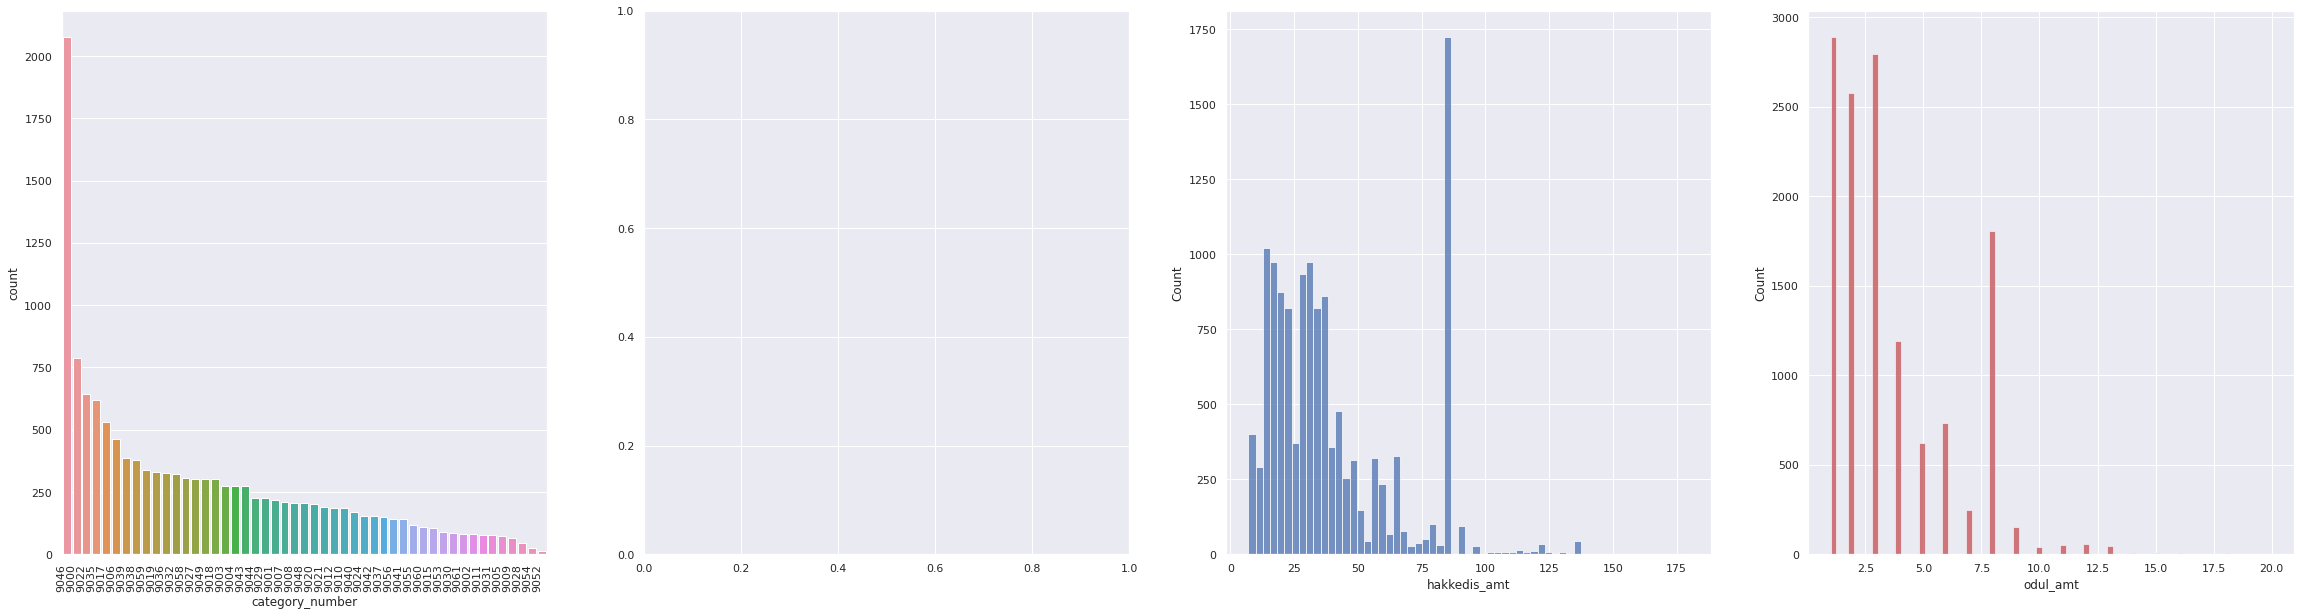

In [42]:
sns.set(context="paper", font="monospace");
sns.set(rc={'figure.figsize':(11.7,8.27)});
f,ax=plt.subplots(1,4,figsize=[40,10]);
sns.countplot(test.category_number,order=test.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.histplot(test.hakkedis_amt,ax=ax[2]);
sns.histplot(test.odul_amt,ax=ax[3],color='r');

### 4-product_groups

In [43]:
product_groups=product_groups.astype({'category_number':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
product_groups.info()
print(f'\n\n')
null_rate(product_groups)
print(f'\n\n')
product_groups.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category_number   3913 non-null   object
 1   category_level_1  3913 non-null   object
 2   category_level_2  3913 non-null   object
 3   category_level_3  3913 non-null   object
 4   category_level_4  3913 non-null   object
dtypes: object(5)
memory usage: 153.0+ KB





,null_rate
category_number,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000


,category_number,category_level_1,category_level_2,category_level_3,category_level_4
count,3913,3913,3913,3913,3913
unique,50,56,41,40,96
top,9035,300,10,10,10
freq,654,521,535,974,839


### 5-transaction_sale

In [44]:
transaction_sale=transaction_sale.astype({'basketid':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
print(f'\n\n')
transaction_sale.info()
print(f'\n\n')
null_rate(transaction_sale)
print(f'\n\n')
transaction_sale.describe(include='all')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537881 entries, 0 to 6537880
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   basketid          object 
 1   category_level_1  object 
 2   category_level_2  object 
 3   category_level_3  object 
 4   category_level_4  object 
 5   amount            float64
 6   quantity          float64
 7   discount_type_1   float64
 8   discount_type_2   float64
 9   discount_type_3   float64
dtypes: float64(5), object(5)
memory usage: 498.8+ MB





,null_rate
discount_type_1,0.711067
discount_type_2,0.000020
discount_type_3,0.000020
basketid,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000
amount,0.000000
quantity,0.000000


,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3
count,6.537881e+06,6537881.0,6537881.0,6537881.0,6537881.0,6.537881e+06,6.537881e+06,1.889008e+06,6.537751e+06,6.537753e+06
unique,1.124327e+06,70.0,40.0,40.0,85.0,NaN,NaN,NaN,NaN,NaN
top,2.105051e+16,130.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN
freq,1.650000e+02,872712.0,1376177.0,2561787.0,2220686.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.678373e+01,1.369372e+00,2.143040e+00,5.479906e-01,1.031550e+00
std,NaN,NaN,NaN,NaN,NaN,4.810842e+01,1.639792e+00,5.657074e+00,4.138239e+00,6.440188e+00
min,NaN,NaN,NaN,NaN,NaN,-8.150400e+03,-9.600000e+01,-5.220884e-04,-1.869100e+02,-2.400000e+02
25%,NaN,NaN,NaN,NaN,NaN,4.750000e+00,1.000000e+00,2.559020e-01,0.000000e+00,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,9.280000e+00,1.000000e+00,7.225458e-01,0.000000e+00,0.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,1.883000e+01,1.012000e+00,1.993273e+00,0.000000e+00,0.000000e+00


### 6-transaction_header

In [45]:
transaction_header=transaction_header.astype({'date_of_transaction':'datetime64','cardnumber':'object','basketid':'object','is_sanal':'object'})
transaction_header.info()
print(f'\n\n')
null_rate(transaction_header)
print(f'\n\n')
transaction_header.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124673 entries, 0 to 1124672
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_of_transaction  1124673 non-null  datetime64[ns]
 1   cardnumber           1124673 non-null  object        
 2   basketid             1124673 non-null  object        
 3   is_sanal             1124673 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.3+ MB





,null_rate
date_of_transaction,0.000000
cardnumber,0.000000
basketid,0.000000
is_sanal,0.000000


,date_of_transaction,cardnumber,basketid,is_sanal
count,1124673,1.124673e+06,1.124673e+06,1124673.0
unique,366,3.031900e+04,1.124673e+06,2.0
top,2020-12-31 00:00:00,9.887855e+15,2.012016e+16,0.0
freq,5032,1.239000e+03,1.000000e+00,1024395.0
first,2020-12-01 00:00:00,NaN,NaN,NaN
last,2021-12-01 00:00:00,NaN,NaN,NaN


### genel_kategoriler

In [46]:
genel_kategoriler=genel_kategoriler.astype({'category_number':'object'})
genel_kategoriler.info()
print(f'\n\n')
null_rate(genel_kategoriler)
print(f'genel_kategoriler shape',genel_kategoriler.shape)
print(f'\n\n')
genel_kategoriler.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category_number  50 non-null     object
 1   genel_kategori   50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes





,null_rate
category_number,0.000000
genel_kategori,0.000000


genel_kategoriler shape (50, 2)





,category_number,genel_kategori
count,50,50
unique,50,5
top,9052,gida
freq,1,30


## Data Preprocessing  and Feature Engineering stages

Merge dataframes and created new features

In [47]:
cinfo=customer.merge(customeraccount,on='individualnumber')
cinfo.loc[cinfo.city_code.isnull(),'city_code']='unknown'
cinfo.loc[cinfo.gender.isnull(),'gender']='E'
cinfo.loc[cinfo.dateofbirth.isnull(),'dateofbirth']=round(cinfo.dateofbirth.mean())
#-------------------
test=sample_submission.merge(test,how='left',on='individualnumber').drop('response',axis=1)
#-------------------
df_train_test=pd.concat([train,test],axis=0)
#-------------------
df_train_test['odul_amt_hakkedis_amt']=df_train_test.odul_amt/df_train_test.hakkedis_amt
dum=df_train_test.groupby('category_number').odul_amt_hakkedis_amt.mean().to_frame().rename(columns={'odul_amt_hakkedis_amt':'odul_amt_hakkedis_amt_gb'})
df_train_test=df_train_test.merge(dum,how='left',on='category_number')
transaction_header['month']=transaction_header.date_of_transaction.dt.month
transaction_header['year']=transaction_header.date_of_transaction.dt.year
transaction_header['day']=transaction_header.date_of_transaction.dt.day
transaction_header['day_of_weak']=transaction_header.date_of_transaction.dt.dayofweek
transaction_sale['amt_quantity_rate']=transaction_sale.amount/transaction_sale.quantity
transaction_sale['sum_discount_type']=transaction_sale[['discount_type_1','discount_type_2', 'discount_type_3']].sum(axis=1)
#----------------------------------------------------------------------
print(f'Train shape :',train.shape)
print(f'Test shape:',test.shape)

cinfo=cinfo[cinfo.individualnumber.isin(df_train_test.individualnumber)] # in here ,We are selecting only individualnumber of df_train_test inside from cinfo dataframe
cinfo=cinfo[cinfo.cardnumber.isin(transaction_header.cardnumber)]
df_train_test=df_train_test.merge(cinfo,on='individualnumber')
df_train_test.loc[df_train_test.hakkedis_amt>140,'hakkedis_amt']=140

# -----------------------------------------------------------------
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')

Train shape : (13115, 5)
Test shape: (13236, 4)


In [48]:
genel_kategoriler.head()

,category_number,genel_kategori
0,9052,diger
1,9053,diger
2,9054,diger
3,9055,gida
4,9056,gida


In [49]:
transaction_header

,date_of_transaction,cardnumber,basketid,is_sanal,month,year,day,day_of_weak
0,2020-12-01,8487374630565615,20120163990041163,0,12,2020,1,1
1,2020-12-01,4287574603569015,20120163990016137,0,12,2020,1,1
3,2020-12-01,3787564693563915,20120163570105022,0,12,2020,1,1
4,2020-12-01,9087994683569715,20120162340016645,0,12,2020,1,1
5,2020-12-01,8687004643564415,20120165320027109,0,12,2020,1,1
...,...,...,...,...,...,...,...,...
1124666,2021-12-01,1487884691566715,21120111210046426,0,12,2021,1,2
1124668,2021-12-01,5187224618568515,21120111950019800,0,12,2021,1,2
1124669,2021-12-01,87714689568015,21120111830079927,0,12,2021,1,2
1124670,2021-12-01,3287454606560415,21120110690047978,0,12,2021,1,2


In [50]:
transaction_sale

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,amt_quantity_rate,sum_discount_type
0,20120706070177471,613,50,50,15,19.90,2.0,NaN,0.0,0.00,9.95,0.00
1,20120706070177471,425,30,12,10,3.50,1.0,NaN,0.0,0.00,3.50,0.00
2,20120706070177471,425,30,12,11,7.90,1.0,NaN,0.0,0.00,7.90,0.00
3,20122703940031323,103,25,15,10,7.90,2.0,NaN,0.0,0.00,3.95,0.00
4,20122703940031323,101,15,15,15,16.00,1.0,NaN,0.0,0.00,16.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6537876,20120839080026509,103,35,10,10,2.95,1.0,NaN,0.0,0.00,2.95,0.00
6537877,20120839080026509,130,85,11,10,3.40,1.0,NaN,0.0,0.00,3.40,0.00
6537878,20120839080026509,131,10,10,20,4.45,1.0,NaN,0.0,0.00,4.45,0.00
6537879,21101831040099839,103,35,10,10,0.01,1.0,NaN,0.0,1.24,0.01,1.24


In [51]:
from sklearn.cluster import KMeans
dum_df=transaction_sale[['category_level_1','category_level_2','category_level_3','category_level_4']]
dum_df=dum_df.astype({'category_level_1':str,'category_level_2':str,'category_level_3':str,'category_level_4':str})
kmeans = KMeans(n_clusters=10, random_state=0).fit(dum_df)
gc.collect()
transaction_sale['category_labels']=kmeans.labels_
transaction_sale['discount_mul']=transaction_sale.discount_type_1.replace(0,1).fillna(1).mul(transaction_sale.discount_type_2.replace(0,1).fillna(1)).mul(transaction_sale.discount_type_3.replace(0,1).fillna(1))

49887

In [52]:
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')  #transaction_sale and transaction_Header merged over baskedid  then merged df_train_test over cardnumber
data=data.merge(genel_kategoriler,on='category_number')
data=pd.concat([data,pd.get_dummies(data.genel_kategori)],axis=1)
data=pd.concat([data,pd.get_dummies(data.category_labels)],axis=1)
gc.collect()

23

In [53]:
data=data.groupby('individualnumber').agg(
gender=('gender','first'),
city_code=('city_code','first'),
dateofbirth=('dateofbirth','first'),
sum_amount=('amount','sum'),  
mean_amount=('amount','mean'),
quantity_sum=('quantity','mean'),
diger_amount=('diger','sum'),    
gida_amount=('gida','sum'),    
hijyen_amount=('hijyen','sum'),
icecek_amount=('icecek','sum'),    
kisisel_bakim_amount=('kisisel_bakim','sum'),    
is_sanal_sayısı=('is_sanal','count'), 
basket_sayısı=('basketid','count'), 
discount_type_1_toplam=('discount_type_1','sum'), 
discount_type_2_toplam=('discount_type_2','sum'), 
discount_type_3_toplam=('discount_type_3','sum'),
day_of_weak_freq=('day_of_weak',lambda x:x.value_counts().index[0]),
day_freq=('day',lambda x:x.value_counts().index[0]),
month_freq=('month',lambda x:x.value_counts().index[0]),
date_diff=('date_of_transaction',lambda x:(x.max()-x.min()).days),
hakkedis_amt=('hakkedis_amt','first'), 
response=('response','first'), 
odul_amt_hakkedis_amt=('odul_amt_hakkedis_amt','first'), 
odul_amt=('odul_amt','count'), 
odul_amt_hakkedis_amt_gb=('odul_amt_hakkedis_amt_gb','first'), 
category_number=('category_number','first'),
sum_discount_type=('sum_discount_type','sum'),
sum_discount_mul=('discount_mul','sum'),

    
L_0=(0,'sum'),         
L_1=(1,'sum') ,    
L_2=(2,'sum')  ,
L_3=(3,'sum')  ,
L_4=(4,'sum')   ,
L_5=(5,'sum')  ,
L_6=(6,'sum')  ,
L_7=(7,'sum')  ,
L_8=(8,'sum')  ,
L_9=(9,'sum')  ,
# L_10=(10,'sum') , 
# L_11=(11,'sum')  ,
# L_12=(12,'sum')  ,     
# L_13=(13,'sum')  ,
# L_14=(14,'sum')  ,
# L_15=(15,'sum')  ,
# L_16=(16,'sum')  ,
# L_17=(17,'sum')  ,
# L_18=(18,'sum')  ,
# L_19=(19,'sum') ,  
    

).reset_index()

data

,individualnumber,gender,city_code,dateofbirth,sum_amount,mean_amount,quantity_sum,diger_amount,gida_amount,hijyen_amount,icecek_amount,kisisel_bakim_amount,is_sanal_sayısı,basket_sayısı,discount_type_1_toplam,discount_type_2_toplam,discount_type_3_toplam,day_of_weak_freq,day_freq,month_freq,date_diff,hakkedis_amt,response,odul_amt_hakkedis_amt,odul_amt,odul_amt_hakkedis_amt_gb,category_number,sum_discount_type,sum_discount_mul,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9
0,356411,K,9.0,1972.0,7131.68,16.859764,1.552830,0.0,423.0,0.0,0.0,0.0,423,423,189.939580,120.22,473.40,5,8,12,359,56.0,NaN,0.089286,423,0.094598,9046,783.559580,1623.380326,104.0,11.0,13.0,56.0,66.0,50.0,52.0,23.0,1,47.0
1,375612,E,34.0,1952.0,61828.69,47.487473,1.880174,0.0,0.0,1302.0,0.0,0.0,1302,1302,201.919945,1758.50,2524.94,0,27,8,364,43.0,NaN,0.139535,1302,0.096982,9022,4485.359945,5389.121175,255.0,2.0,137.0,60.0,61.0,134.0,302.0,22.0,86,243.0
2,393158,E,26.0,1973.0,3792.19,22.047616,2.640017,0.0,172.0,0.0,0.0,0.0,172,172,363.152444,263.23,300.27,4,17,6,362,7.0,NaN,0.142857,172,0.117774,9003,926.652444,2287.884853,28.0,1.0,10.0,24.0,26.0,23.0,36.0,13.0,0,11.0
3,452480,K,6.0,1946.0,8514.57,13.200884,1.157322,0.0,0.0,645.0,0.0,0.0,645,645,200.276362,191.73,400.18,0,4,6,356,43.0,0.0,0.139535,645,0.096982,9022,792.186362,1616.753783,56.0,16.0,17.0,87.0,30.0,30.0,297.0,56.0,0,56.0
4,643968,K,34.0,1946.0,6049.92,15.200804,0.968535,0.0,398.0,0.0,0.0,0.0,398,398,306.889998,197.60,198.07,4,11,12,360,15.0,NaN,0.066667,398,0.073560,9017,702.559998,1132.618837,10.0,15.0,17.0,27.0,42.0,10.0,265.0,2.0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26331,102278919,K,unknown,1996.0,147.64,16.404444,1.555556,0.0,9.0,0.0,0.0,0.0,9,9,0.000000,10.00,2.06,5,27,11,0,10.0,0.0,0.100000,9,0.073560,9017,12.060000,19.060000,0.0,0.0,0.0,2.0,1.0,3.0,0.0,1.0,1,1.0
26332,102279267,K,unknown,1991.0,97.30,9.730000,1.000000,0.0,10.0,0.0,0.0,0.0,10,10,0.000000,0.00,0.00,0,29,11,0,10.0,0.0,0.100000,10,0.073560,9017,0.000000,10.000000,0.0,0.0,0.0,5.0,1.0,0.0,4.0,0.0,0,0.0
26333,102280492,K,34.0,1986.0,73.35,10.478571,1.000000,0.0,7.0,0.0,0.0,0.0,7,7,0.000000,10.00,10.00,0,29,11,0,10.0,NaN,0.100000,7,0.073560,9017,20.000000,106.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1,3.0
26334,102280832,K,1.0,1983.0,54.35,13.587500,1.500000,0.0,4.0,0.0,0.0,0.0,4,4,0.000000,1.50,6.90,6,7,11,4,10.0,0.0,0.100000,4,0.073560,9017,8.400000,10.400000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1.0


In [54]:
data_end=data.copy()

data_end=data_end.astype({'day_of_weak_freq':str,
                 'day_freq':str,
                 'month_freq':str,
                 'category_number':str,
                 'gender':str,
                 'city_code':str})

cat_features=['day_of_weak_freq', 'gender','city_code','day_freq',
              'month_freq','category_number']
data_end['günlük_ort_harcama']=data_end.date_diff/data_end.sum_amount
print(f'data_end shape',data_end.shape)

# -----------------------------
Le=LabelEncoder()
data_end.loc[:,cat_features]=data_end[cat_features].apply(lambda x: Le.fit_transform(x),axis=0)
# ------------------------------------------------------------------------------------------------------------
data_train=data_end[data_end.response.notnull()].drop('response',axis=1)
target_train=data_end[data_end.response.notnull()].response
data_test=data_end[data_end.response.isnull()].drop('response',axis=1)
test_id=data_test.individualnumber
data_test.drop(['individualnumber'],axis=1,inplace=True)
train_id=data_train.individualnumber
data_train.drop(['individualnumber'],axis=1,inplace=True)
print(f'data_train shape',data_train.shape)
print(f'data_test shape',data_test.shape)

data_end shape (26336, 40)
data_train shape (13111, 38)
data_test shape (13225, 38)


# XGBOOST MODEL

 I used the XGBOOST model for train data and used 'optuna' in order to tune the model. when ı do this ,I selected KFold. inside each fold determined the optimum threshold using with calculate_optimum_threshold  function

##  Model optimization with optuna

In [55]:
from sklearn import metrics
def objective(trial,data=data_train,target=target_train):
    
    param = {'use_label_encoder':False,            
              'eval_metric':'logloss',
             "objective": "binary:logistic",
            'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
             'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
             'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2,0.5]),
             'n_estimators': 300,
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.0, 100.0),

#                'scale_pos_weight':60,
#              'early_stopping_rounds':100

    } 
  
    score_list1=[]
    kf = KFold(n_splits=3, shuffle=True)
    folds=list(kf.split(data_train,target_train))
    thresholds=[]
    for train_index, test_index in folds:
        X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
        y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  
        val_set=[(X_val, y_val)]

        model = xgb.XGBClassifier(**param)  
        model.fit(X_train,y_train, eval_set=val_set,verbose=0)


        preds = model.predict_proba(X_val)[:, 1]
        threshold, val_score = calculate_optimum_threshold(y_val, preds)
        f1score = classification_scores(y_val, preds, threshold=threshold)

        score_list1.append( list(f1score.values())[0])
        thresholds.append(threshold)
    score=np.mean(score_list1)
    
    print(f"treshold mean : {np.mean(thresholds)}")
    print('-----------------------')
    print('-----------------------')
    return score
    


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

[I 2022-12-31 22:40:01,488] A new study created in memory with name: no-name-2bf8ce92-0add-4ef1-8c28-d0fd2f680224


Optimum threshold: 0.48, Score: 0.31627906976744186
Optimum threshold: 0.4, Score: 0.3796296296296296


[I 2022-12-31 22:40:03,774] Trial 0 finished with value: 0.36383769833382235 and parameters: {'lambda': 5.093919668988398, 'alpha': 9.83992162324801, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 39, 'scale_pos_weight': 97.31352525661424}. Best is trial 0 with value: 0.36383769833382235.


Optimum threshold: 0.4, Score: 0.39560439560439564
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.38, Score: 0.2222222222222222


[I 2022-12-31 22:40:05,127] Trial 1 finished with value: 0.14303959131545338 and parameters: {'lambda': 3.7692172788289526, 'alpha': 8.021731361964397, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 134, 'scale_pos_weight': 4.139309796926652}. Best is trial 0 with value: 0.36383769833382235.


Optimum threshold: 0.4, Score: 0.20689655172413796
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3155216284987277
Optimum threshold: 0.58, Score: 0.21483375959079284


[I 2022-12-31 22:40:15,932] Trial 2 finished with value: 0.26432721690526106 and parameters: {'lambda': 7.212292297775013, 'alpha': 5.241351719222036, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 154, 'scale_pos_weight': 45.737157074626595}. Best is trial 0 with value: 0.36383769833382235.


Optimum threshold: 0.58, Score: 0.2626262626262626
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40375586854460094
Optimum threshold: 0.58, Score: 0.3962264150943396


[I 2022-12-31 22:40:27,038] Trial 3 finished with value: 0.3878728824251014 and parameters: {'lambda': 7.105981423883514, 'alpha': 7.163678878612947, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 53, 'scale_pos_weight': 14.755103376317642}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.56, Score: 0.36363636363636365
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.27083333333333337
Optimum threshold: 0.58, Score: 0.2476635514018692


[I 2022-12-31 22:40:29,559] Trial 4 finished with value: 0.23657045167314675 and parameters: {'lambda': 0.42644952616657134, 'alpha': 9.477155854744225, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 132, 'scale_pos_weight': 74.71765676315141}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.58, Score: 0.19121447028423774
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.330188679245283
Optimum threshold: 0.58, Score: 0.42328042328042326


[I 2022-12-31 22:40:33,565] Trial 5 finished with value: 0.38574165702343577 and parameters: {'lambda': 1.5605757116639716, 'alpha': 7.183145559784496, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 46.584377350215256}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.52, Score: 0.40375586854460094
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.31168831168831174
Optimum threshold: 0.58, Score: 0.38202247191011235


[I 2022-12-31 22:40:36,512] Trial 6 finished with value: 0.3238922950977798 and parameters: {'lambda': 2.9853842139582567, 'alpha': 2.1514301998579612, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 87, 'scale_pos_weight': 24.841684408592535}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.58, Score: 0.27796610169491526
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2579185520361991
Optimum threshold: 0.58, Score: 0.25692695214105793


[I 2022-12-31 22:40:38,763] Trial 7 finished with value: 0.2509400625738536 and parameters: {'lambda': 1.939877239841365, 'alpha': 4.587130708981946, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 110, 'scale_pos_weight': 87.48614621284702}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.58, Score: 0.2379746835443038
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3243243243243243
Optimum threshold: 0.58, Score: 0.28668941979522183


[I 2022-12-31 22:40:40,359] Trial 8 finished with value: 0.2979906478254864 and parameters: {'lambda': 1.393768389746652, 'alpha': 7.921469992421647, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 240, 'scale_pos_weight': 21.386632862877143}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.54, Score: 0.28295819935691313
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:40:42,812] Trial 9 finished with value: 0.0 and parameters: {'lambda': 2.3306295707737377, 'alpha': 4.710597021980891, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 181, 'scale_pos_weight': 3.634277729821891}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.380952380952381
Optimum threshold: 0.58, Score: 0.30175438596491233


[I 2022-12-31 22:40:46,055] Trial 10 finished with value: 0.3235285182653604 and parameters: {'lambda': 9.743402679701326, 'alpha': 1.0702297817075221, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 64, 'scale_pos_weight': 64.38755501112755}. Best is trial 3 with value: 0.3878728824251014.


Optimum threshold: 0.58, Score: 0.28787878787878785
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.36792452830188677
Optimum threshold: 0.58, Score: 0.3135593220338983


[I 2022-12-31 22:40:49,416] Trial 11 finished with value: 0.3922988981241608 and parameters: {'lambda': 7.0079477704845505, 'alpha': 6.695230034022428, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 8, 'scale_pos_weight': 42.596803323783945}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.4954128440366973
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3814432989690722
Optimum threshold: 0.52, Score: 0.35


[I 2022-12-31 22:41:01,948] Trial 12 finished with value: 0.37222973353613886 and parameters: {'lambda': 7.130052856853461, 'alpha': 6.386096992829385, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 4, 'scale_pos_weight': 30.677389316329446}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.38524590163934425
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3293172690763052
Optimum threshold: 0.58, Score: 0.2706270627062706


[I 2022-12-31 22:41:03,888] Trial 13 finished with value: 0.3209935451376463 and parameters: {'lambda': 7.134513887444042, 'alpha': 3.3996964680878494, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 59, 'scale_pos_weight': 32.76089935848383}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.36303630363036304
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3391304347826087
Optimum threshold: 0.58, Score: 0.40201005025125625


[I 2022-12-31 22:41:18,360] Trial 14 finished with value: 0.38721776851556183 and parameters: {'lambda': 9.17735360077535, 'alpha': 6.384628256610694, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 56.75958560320499}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.4205128205128205
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.15434083601286172
Optimum threshold: 0.44, Score: 0.17391304347826086


[I 2022-12-31 22:41:19,732] Trial 15 finished with value: 0.16829735204309978 and parameters: {'lambda': 5.561227695078857, 'alpha': 8.614040859296756, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 275, 'scale_pos_weight': 12.600026274465563}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.46, Score: 0.17663817663817666
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25210084033613445
Optimum threshold: 0.58, Score: 0.2884012539184953


[I 2022-12-31 22:41:21,374] Trial 16 finished with value: 0.2827314673156458 and parameters: {'lambda': 8.440925000764386, 'alpha': 5.949615078559815, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 194, 'scale_pos_weight': 38.805332413778515}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.3076923076923077
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38383838383838387
Optimum threshold: 0.56, Score: 0.33620689655172414


[I 2022-12-31 22:41:23,761] Trial 17 finished with value: 0.36483778849883036 and parameters: {'lambda': 5.950193490742337, 'alpha': 3.1784758677465534, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 85, 'scale_pos_weight': 16.735652553494145}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.374468085106383
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32051282051282054
Optimum threshold: 0.54, Score: 0.30952380952380953


[I 2022-12-31 22:41:25,852] Trial 18 finished with value: 0.29902736152736153 and parameters: {'lambda': 8.198407898594496, 'alpha': 7.148612467844291, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 45, 'scale_pos_weight': 60.96505920484548}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.26704545454545453
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.39676113360323884
Optimum threshold: 0.58, Score: 0.3358208955223881


[I 2022-12-31 22:41:28,827] Trial 19 finished with value: 0.35481991946108965 and parameters: {'lambda': 3.9021293790342764, 'alpha': 8.862539821634583, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 30, 'scale_pos_weight': 40.92938553225143}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.3318777292576419
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.296028880866426
Optimum threshold: 0.56, Score: 0.33834586466165417


[I 2022-12-31 22:41:30,462] Trial 20 finished with value: 0.31687135392246546 and parameters: {'lambda': 6.3745456809466985, 'alpha': 5.513488695143778, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 93, 'scale_pos_weight': 71.22499429170733}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.3162393162393162
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4444444444444445
Optimum threshold: 0.58, Score: 0.37209302325581395


[I 2022-12-31 22:41:43,889] Trial 21 finished with value: 0.38680962347173015 and parameters: {'lambda': 9.95533033302597, 'alpha': 6.948620735747844, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 2, 'scale_pos_weight': 54.14277073732451}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.34389140271493207
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3790322580645161
Optimum threshold: 0.56, Score: 0.32234432234432236


[I 2022-12-31 22:41:55,297] Trial 22 finished with value: 0.348296010263506 and parameters: {'lambda': 9.04750379442236, 'alpha': 6.209765664510845, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 28, 'scale_pos_weight': 53.54750945854195}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.3435114503816794
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3038674033149172
Optimum threshold: 0.58, Score: 0.2591549295774648


[I 2022-12-31 22:42:06,720] Trial 23 finished with value: 0.2763060955498691 and parameters: {'lambda': 8.014884896936065, 'alpha': 7.854091574312465, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 69, 'scale_pos_weight': 79.49363791689612}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.2658959537572254
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4081632653061224
Optimum threshold: 0.32, Score: 0.3529411764705882


[I 2022-12-31 22:42:19,664] Trial 24 finished with value: 0.3733596002503565 and parameters: {'lambda': 8.960149716688097, 'alpha': 4.109970169658186, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 61.76846702360636}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.5, Score: 0.358974358974359
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33212996389891697
Optimum threshold: 0.58, Score: 0.3453237410071942


[I 2022-12-31 22:42:30,976] Trial 25 finished with value: 0.35117402699149575 and parameters: {'lambda': 6.56332581482653, 'alpha': 6.764301603486896, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 47, 'scale_pos_weight': 32.13858284402639}. Best is trial 11 with value: 0.3922988981241608.


Optimum threshold: 0.58, Score: 0.3760683760683761
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4338624338624339
Optimum threshold: 0.52, Score: 0.4444444444444444


[I 2022-12-31 22:42:34,352] Trial 26 finished with value: 0.41477331673410106 and parameters: {'lambda': 7.936195959180207, 'alpha': 5.432714664831913, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 13.083212041815152}. Best is trial 26 with value: 0.41477331673410106.


Optimum threshold: 0.58, Score: 0.3660130718954248
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3779527559055118
Optimum threshold: 0.58, Score: 0.3686635944700461


[I 2022-12-31 22:42:36,363] Trial 27 finished with value: 0.3697512376709735 and parameters: {'lambda': 7.612715327465999, 'alpha': 3.9135199707391637, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 110, 'scale_pos_weight': 13.67840195192709}. Best is trial 26 with value: 0.41477331673410106.


Optimum threshold: 0.54, Score: 0.3626373626373626
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5238095238095238
Optimum threshold: 0.58, Score: 0.3355704697986577


[I 2022-12-31 22:42:39,052] Trial 28 finished with value: 0.40388424029363623 and parameters: {'lambda': 4.854037119406842, 'alpha': 5.209248432115698, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 24, 'scale_pos_weight': 8.976387008075342}. Best is trial 26 with value: 0.41477331673410106.


Optimum threshold: 0.46, Score: 0.3522727272727273
treshold mean : 0.5399999999999999
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.44186046511627913
Optimum threshold: 0.56, Score: 0.3846153846153846


[I 2022-12-31 22:42:41,519] Trial 29 finished with value: 0.41376355484882615 and parameters: {'lambda': 4.8547273847216434, 'alpha': 5.4724063303126425, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 8.09048049201695}. Best is trial 26 with value: 0.41477331673410106.


Optimum threshold: 0.58, Score: 0.4148148148148148
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41916167664670656
Optimum threshold: 0.5, Score: 0.3953488372093023


[I 2022-12-31 22:42:44,035] Trial 30 finished with value: 0.4201234621558247 and parameters: {'lambda': 4.750084918472178, 'alpha': 2.5239056311831667, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 8.658974747501418}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.445859872611465
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.41379310344827586
Optimum threshold: 0.44, Score: 0.40476190476190477


[I 2022-12-31 22:42:46,903] Trial 31 finished with value: 0.41761357416529826 and parameters: {'lambda': 4.753944677613963, 'alpha': 0.06294538767408087, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 31, 'scale_pos_weight': 7.6671786481378135}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.54, Score: 0.4342857142857142
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4228571428571429
Optimum threshold: 0.48, Score: 0.4666666666666667


[I 2022-12-31 22:42:48,725] Trial 32 finished with value: 0.4177200577200577 and parameters: {'lambda': 4.527039645802046, 'alpha': 0.5828199190733843, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 35, 'scale_pos_weight': 3.0865362688819005}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.42, Score: 0.3636363636363636
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.39215686274509803
Optimum threshold: 0.44, Score: 0.3832335329341317


[I 2022-12-31 22:42:50,455] Trial 33 finished with value: 0.392691653145873 and parameters: {'lambda': 4.299081475909656, 'alpha': 0.051546343415945106, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 71, 'scale_pos_weight': 4.673092445248951}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.52, Score: 0.4026845637583893
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3389830508474576
Optimum threshold: 0.34, Score: 0.3238095238095238


[I 2022-12-31 22:42:52,137] Trial 34 finished with value: 0.316168953457089 and parameters: {'lambda': 3.631482102403085, 'alpha': 0.4818246883723935, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 1.235422471820793}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.3, Score: 0.2857142857142857
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3628691983122363
Optimum threshold: 0.58, Score: 0.3507462686567164


[I 2022-12-31 22:42:54,285] Trial 35 finished with value: 0.34023402704739364 and parameters: {'lambda': 5.3572679705499535, 'alpha': 1.761263983551635, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 116, 'scale_pos_weight': 22.44643357025482}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.3070866141732283
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3557692307692307
Optimum threshold: 0.56, Score: 0.36180904522613067


[I 2022-12-31 22:42:57,013] Trial 36 finished with value: 0.3826905165126541 and parameters: {'lambda': 3.0483433067528614, 'alpha': 1.3576321762475603, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 47, 'scale_pos_weight': 17.095735751268556}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.5, Score: 0.4304932735426009
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4122807017543859
Optimum threshold: 0.58, Score: 0.35714285714285715


[I 2022-12-31 22:42:58,712] Trial 37 finished with value: 0.3799313097558712 and parameters: {'lambda': 4.191583998372229, 'alpha': 2.5802805308942385, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 144, 'scale_pos_weight': 9.074933500809767}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.52, Score: 0.37037037037037035
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33976833976833976
Optimum threshold: 0.58, Score: 0.368


[I 2022-12-31 22:43:00,976] Trial 38 finished with value: 0.3341683939578676 and parameters: {'lambda': 3.2590746628238625, 'alpha': 0.8475440121734539, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 78, 'scale_pos_weight': 25.838415284187988}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.29473684210526313
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.37623762376237624
Optimum threshold: 0.56, Score: 0.47058823529411764


[I 2022-12-31 22:43:05,846] Trial 39 finished with value: 0.4130567855547165 and parameters: {'lambda': 4.7539028467301945, 'alpha': 0.058644467747812803, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 18.09866475254776}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.48, Score: 0.39234449760765544
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.32365145228215764
Optimum threshold: 0.46, Score: 0.3601895734597156


[I 2022-12-31 22:43:08,381] Trial 40 finished with value: 0.35274175406502506 and parameters: {'lambda': 6.106096855577184, 'alpha': 2.3439249176434886, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 168, 'scale_pos_weight': 7.880777876196266}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.37438423645320196
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4180790960451978
Optimum threshold: 0.54, Score: 0.43181818181818177


[I 2022-12-31 22:43:11,042] Trial 41 finished with value: 0.41095866708921164 and parameters: {'lambda': 4.645609163188638, 'alpha': 1.5428062533025644, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 9.739506105836293}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.48, Score: 0.3829787234042554
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3103448275862069
Optimum threshold: 0.3, Score: 0.39263803680981596


[I 2022-12-31 22:43:12,558] Trial 42 finished with value: 0.3608483027305478 and parameters: {'lambda': 5.2466411651603675, 'alpha': 0.7491707919044841, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 55, 'scale_pos_weight': 1.8673131770105362}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.3, Score: 0.3795620437956205
treshold mean : 0.32666666666666666
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.33548387096774196
Optimum threshold: 0.3, Score: 0.3511450381679389


[I 2022-12-31 22:43:14,482] Trial 43 finished with value: 0.35885533868464 and parameters: {'lambda': 5.695338097469164, 'alpha': 5.69193072111143, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 5.720564659484135}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.34, Score: 0.389937106918239
treshold mean : 0.32
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3902439024390244
Optimum threshold: 0.48, Score: 0.3058823529411765


[I 2022-12-31 22:43:16,060] Trial 44 finished with value: 0.35118023468313414 and parameters: {'lambda': 4.3965936343368535, 'alpha': 4.3809359040653355, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 99, 'scale_pos_weight': 13.209528438009638}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.3574144486692015
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.383419689119171
Optimum threshold: 0.58, Score: 0.3668122270742359


[I 2022-12-31 22:43:19,455] Trial 45 finished with value: 0.3775282857899591 and parameters: {'lambda': 2.6536179649191975, 'alpha': 5.0395910403067345, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 40, 'scale_pos_weight': 20.27169204216034}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.56, Score: 0.38235294117647056
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25981873111782483
Optimum threshold: 0.56, Score: 0.254054054054054


[I 2022-12-31 22:43:22,233] Trial 46 finished with value: 0.27156947992265973 and parameters: {'lambda': 3.5734248380545326, 'alpha': 2.6460514453543467, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 61, 'scale_pos_weight': 97.97144094524538}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.3008356545961003
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4974093264248704
Optimum threshold: 0.58, Score: 0.3459459459459459


[I 2022-12-31 22:43:26,437] Trial 47 finished with value: 0.39676468262700676 and parameters: {'lambda': 4.946859583351431, 'alpha': 3.398224311174654, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 27.85555653349407}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.346938775510204
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.37647058823529417
Optimum threshold: 0.58, Score: 0.4777777777777778


[I 2022-12-31 22:43:28,817] Trial 48 finished with value: 0.4092474473055621 and parameters: {'lambda': 0.22207886274540645, 'alpha': 1.8041224888435583, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 54, 'scale_pos_weight': 10.860873774070098}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.3734939759036144
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.16853932584269662
Optimum threshold: 0.32, Score: 0.18181818181818185


[I 2022-12-31 22:43:31,257] Trial 49 finished with value: 0.21053583588695948 and parameters: {'lambda': 6.624600864692666, 'alpha': 1.1135271929497652, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 232, 'scale_pos_weight': 5.332819053483184}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.34, Score: 0.28125
treshold mean : 0.34
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3973509933774835
Optimum threshold: 0.48, Score: 0.46060606060606063


[I 2022-12-31 22:43:33,247] Trial 50 finished with value: 0.40092821339681356 and parameters: {'lambda': 1.093074039180991, 'alpha': 0.43207250693495786, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 91.20541973942943}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.52, Score: 0.3448275862068966
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4431818181818182
Optimum threshold: 0.5, Score: 0.4397905759162304


[I 2022-12-31 22:43:38,230] Trial 51 finished with value: 0.417780921489473 and parameters: {'lambda': 4.649017527325, 'alpha': 0.04638159327777571, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 20.011245565602845}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.3703703703703704
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4302325581395349
Optimum threshold: 0.58, Score: 0.4083769633507853


[I 2022-12-31 22:43:41,664] Trial 52 finished with value: 0.40144126906820193 and parameters: {'lambda': 3.893540589006527, 'alpha': 0.4720073799217079, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 34, 'scale_pos_weight': 14.852034703352626}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.56, Score: 0.3657142857142857
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40476190476190477
Optimum threshold: 0.54, Score: 0.41250000000000003


[I 2022-12-31 22:43:47,542] Trial 53 finished with value: 0.40503712237583206 and parameters: {'lambda': 5.215084519028589, 'alpha': 0.02453108975717421, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 20.190563276584214}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.56, Score: 0.39784946236559143
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.3, Score: 0.04938271604938271


[I 2022-12-31 22:43:49,276] Trial 54 finished with value: 0.10796417332365044 and parameters: {'lambda': 5.769395235391222, 'alpha': 4.847131639048224, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 74, 'scale_pos_weight': 1.574909972907994}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.3, Score: 0.2745098039215686
treshold mean : 0.3933333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4294478527607362
Optimum threshold: 0.46, Score: 0.35359116022099446


[I 2022-12-31 22:43:53,098] Trial 55 finished with value: 0.40118394449818373 and parameters: {'lambda': 4.5357762745802495, 'alpha': 2.091247146585206, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 23.86517314183729}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.42051282051282046
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.34210526315789475
Optimum threshold: 0.58, Score: 0.3486238532110092


[I 2022-12-31 22:43:56,785] Trial 56 finished with value: 0.34213115067774663 and parameters: {'lambda': 3.349596016536591, 'alpha': 1.3077661533382514, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 42, 'scale_pos_weight': 36.70901004581398}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.58, Score: 0.33566433566433573
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.43037974683544306
Optimum threshold: 0.58, Score: 0.3670886075949367


[I 2022-12-31 22:43:58,624] Trial 57 finished with value: 0.4104010980631387 and parameters: {'lambda': 4.067268196661501, 'alpha': 0.7588706604624174, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 60, 'scale_pos_weight': 5.962390384632619}. Best is trial 30 with value: 0.4201234621558247.


Optimum threshold: 0.54, Score: 0.43373493975903615
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3741935483870968
Optimum threshold: 0.4, Score: 0.45454545454545453


[I 2022-12-31 22:44:00,773] Trial 58 finished with value: 0.42248289345063544 and parameters: {'lambda': 2.456432652974172, 'alpha': 5.485071700439938, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 12.315517324930445}. Best is trial 58 with value: 0.42248289345063544.


Optimum threshold: 0.4, Score: 0.43870967741935485
treshold mean : 0.39333333333333337
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.42603550295857984
Optimum threshold: 0.52, Score: 0.43795620437956206


[I 2022-12-31 22:44:02,991] Trial 59 finished with value: 0.4232629362624724 and parameters: {'lambda': 2.1171945277812, 'alpha': 5.901298190292079, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 9, 'scale_pos_weight': 47.032518274534105}. Best is trial 59 with value: 0.4232629362624724.


Optimum threshold: 0.58, Score: 0.40579710144927533
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.325
Optimum threshold: 0.58, Score: 0.4567901234567901


[I 2022-12-31 22:44:05,263] Trial 60 finished with value: 0.39022633744855967 and parameters: {'lambda': 2.1616321305472446, 'alpha': 7.537019430584799, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 7, 'scale_pos_weight': 48.68685109729172}. Best is trial 59 with value: 0.4232629362624724.


Optimum threshold: 0.52, Score: 0.3888888888888889
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.38636363636363635
Optimum threshold: 0.42, Score: 0.4246575342465754


[I 2022-12-31 22:44:07,383] Trial 61 finished with value: 0.43074139270966955 and parameters: {'lambda': 1.0494797960201447, 'alpha': 6.150046109473122, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 13, 'scale_pos_weight': 12.747515254275879}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.44, Score: 0.48120300751879697
treshold mean : 0.39999999999999997
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4383561643835617
Optimum threshold: 0.38, Score: 0.38461538461538464


[I 2022-12-31 22:44:09,625] Trial 62 finished with value: 0.409400102389627 and parameters: {'lambda': 0.7654618329003695, 'alpha': 6.055262729476256, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 6, 'scale_pos_weight': 28.25645876224672}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.46, Score: 0.4052287581699346
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.2763157894736842
Optimum threshold: 0.58, Score: 0.3225806451612903


[I 2022-12-31 22:44:10,927] Trial 63 finished with value: 0.2955917408379208 and parameters: {'lambda': 1.59716029489948, 'alpha': 6.56989883438799, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 299, 'scale_pos_weight': 17.901154295902522}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.28787878787878785
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39325842696629215
Optimum threshold: 0.58, Score: 0.40816326530612246


[I 2022-12-31 22:44:12,901] Trial 64 finished with value: 0.3826521152459204 and parameters: {'lambda': 2.5056297248997326, 'alpha': 5.794305047736856, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 48, 'scale_pos_weight': 68.33092269891382}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.48, Score: 0.3465346534653465
treshold mean : 0.5466666666666666
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3766233766233766
Optimum threshold: 0.58, Score: 0.39215686274509803


[I 2022-12-31 22:44:14,972] Trial 65 finished with value: 0.37321914411697693 and parameters: {'lambda': 1.9547812400216025, 'alpha': 6.285444887289156, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 45.17721060211944}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.3508771929824562
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3657142857142857
Optimum threshold: 0.48, Score: 0.44444444444444436


[I 2022-12-31 22:44:17,044] Trial 66 finished with value: 0.38543752543752546 and parameters: {'lambda': 0.6966691334487249, 'alpha': 9.928988750020734, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 26, 'scale_pos_weight': 80.71135272885267}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.4, Score: 0.3461538461538462
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3
Optimum threshold: 0.58, Score: 0.34375


[I 2022-12-31 22:44:18,362] Trial 67 finished with value: 0.31690891472868216 and parameters: {'lambda': 1.287149244369233, 'alpha': 4.475830269700348, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 207, 'scale_pos_weight': 12.244159193412141}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.56, Score: 0.30697674418604654
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.34782608695652173
Optimum threshold: 0.3, Score: 0.32116788321167883


[I 2022-12-31 22:44:21,000] Trial 68 finished with value: 0.3733739299056909 and parameters: {'lambda': 2.779548736736119, 'alpha': 0.3217841551242831, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 2, 'scale_pos_weight': 15.009041936413764}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.36, Score: 0.4511278195488722
treshold mean : 0.32
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3906976744186047
Optimum threshold: 0.58, Score: 0.3451776649746192


[I 2022-12-31 22:44:24,612] Trial 69 finished with value: 0.39069644372092377 and parameters: {'lambda': 1.5875201097183806, 'alpha': 3.684146692166884, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 38, 'scale_pos_weight': 33.95446268326631}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.5, Score: 0.4362139917695474
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.40277777777777773
Optimum threshold: 0.42, Score: 0.3790849673202614


[I 2022-12-31 22:44:26,570] Trial 70 finished with value: 0.39395424836601306 and parameters: {'lambda': 1.8216590784996949, 'alpha': 0.9792048378027216, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 3.2996009914354687}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.46, Score: 0.4000000000000001
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4019138755980861
Optimum threshold: 0.48, Score: 0.40625000000000006


[I 2022-12-31 22:44:29,260] Trial 71 finished with value: 0.3989117680565049 and parameters: {'lambda': 1.044461962808393, 'alpha': 5.320324173206789, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 14, 'scale_pos_weight': 11.587260608044875}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.3885714285714285
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.49006622516556286
Optimum threshold: 0.4, Score: 0.3764705882352941


[I 2022-12-31 22:44:31,157] Trial 72 finished with value: 0.395512271133619 and parameters: {'lambda': 5.480571558019542, 'alpha': 5.922319547350976, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 6.75001265749597}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.32, Score: 0.32
treshold mean : 0.38000000000000006
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.33519553072625696
Optimum threshold: 0.58, Score: 0.4528301886792453


[I 2022-12-31 22:44:35,744] Trial 73 finished with value: 0.4041846737640982 and parameters: {'lambda': 2.3655296435886317, 'alpha': 5.028580355577282, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 18, 'scale_pos_weight': 15.816496626634937}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.54, Score: 0.42452830188679247
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4
Optimum threshold: 0.32, Score: 0.35071090047393366


[I 2022-12-31 22:44:37,317] Trial 74 finished with value: 0.3531781432952328 and parameters: {'lambda': 6.149340033552235, 'alpha': 5.57492780136516, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 21.054344927965616}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.3088235294117647
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3297872340425532
Optimum threshold: 0.58, Score: 0.3962264150943396


[I 2022-12-31 22:44:40,026] Trial 75 finished with value: 0.3645755512070659 and parameters: {'lambda': 3.151095235753521, 'alpha': 6.534946031790688, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 128, 'scale_pos_weight': 11.059178284846457}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.54, Score: 0.3677130044843049
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.41600000000000004
Optimum threshold: 0.36, Score: 0.4383561643835616


[I 2022-12-31 22:44:42,981] Trial 76 finished with value: 0.395896499238965 and parameters: {'lambda': 0.11517126529978228, 'alpha': 7.02082618710762, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 7.8176501779649055}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.52, Score: 0.3333333333333333
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36458333333333326
Optimum threshold: 0.58, Score: 0.4055299539170507


[I 2022-12-31 22:44:45,086] Trial 77 finished with value: 0.3678155401945724 and parameters: {'lambda': 4.221466890790342, 'alpha': 2.8892215143665934, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 66, 'scale_pos_weight': 18.112805400532075}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.3333333333333333
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4076433121019109
Optimum threshold: 0.56, Score: 0.45833333333333337


[I 2022-12-31 22:44:47,069] Trial 78 finished with value: 0.43032554847841475 and parameters: {'lambda': 4.9771948134891595, 'alpha': 4.687950213174543, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 4.307610371880742}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.44, Score: 0.425
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:44:48,260] Trial 79 finished with value: 0.0 and parameters: {'lambda': 4.960440675874849, 'alpha': 7.390290187899354, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 80, 'scale_pos_weight': 2.781550717331848}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40437158469945356
Optimum threshold: 0.54, Score: 0.38095238095238104


[I 2022-12-31 22:44:50,580] Trial 80 finished with value: 0.42282334435585495 and parameters: {'lambda': 3.512662969987449, 'alpha': 0.37455094963706204, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 50, 'scale_pos_weight': 8.534947975256188}. Best is trial 61 with value: 0.43074139270966955.


Optimum threshold: 0.56, Score: 0.48314606741573035
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4967320261437908
Optimum threshold: 0.46, Score: 0.40414507772020725


[I 2022-12-31 22:44:52,801] Trial 81 finished with value: 0.43570903462133265 and parameters: {'lambda': 3.590183927785997, 'alpha': 0.2790339608212914, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 50, 'scale_pos_weight': 4.776521006477166}. Best is trial 81 with value: 0.43570903462133265.


Optimum threshold: 0.58, Score: 0.40624999999999994
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.1149425287356322
Optimum threshold: 0.3, Score: 0.2222222222222222


[I 2022-12-31 22:44:54,225] Trial 82 finished with value: 0.2316294427312089 and parameters: {'lambda': 3.5403280025385135, 'alpha': 0.6090531558915749, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 35, 'scale_pos_weight': 1.0026227978878306}. Best is trial 81 with value: 0.43570903462133265.


Optimum threshold: 0.3, Score: 0.3577235772357723
treshold mean : 0.3
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.3884892086330935
Optimum threshold: 0.5, Score: 0.44186046511627913


[I 2022-12-31 22:44:55,950] Trial 83 finished with value: 0.413535361335261 and parameters: {'lambda': 2.8387135443166662, 'alpha': 1.249730390128184, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 51, 'scale_pos_weight': 3.5962960534119675}. Best is trial 81 with value: 0.43570903462133265.


Optimum threshold: 0.48, Score: 0.41025641025641024
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4512820512820513
Optimum threshold: 0.54, Score: 0.36111111111111105


[I 2022-12-31 22:44:58,168] Trial 84 finished with value: 0.40062228220122953 and parameters: {'lambda': 3.8795333170742605, 'alpha': 0.23885428251088625, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 54, 'scale_pos_weight': 10.1705857135911}. Best is trial 81 with value: 0.43570903462133265.


Optimum threshold: 0.56, Score: 0.38947368421052625
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.46511627906976744
Optimum threshold: 0.4, Score: 0.4472049689440994


[I 2022-12-31 22:45:00,639] Trial 85 finished with value: 0.44059002230383487 and parameters: {'lambda': 4.552633948551622, 'alpha': 4.281948412013693, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 5.09327006150827}. Best is trial 85 with value: 0.44059002230383487.


Optimum threshold: 0.56, Score: 0.4094488188976378
treshold mean : 0.46666666666666673
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.41333333333333333
Optimum threshold: 0.46, Score: 0.4294478527607362


[I 2022-12-31 22:45:03,211] Trial 86 finished with value: 0.4364826175869121 and parameters: {'lambda': 3.3610883794694475, 'alpha': 5.168194550888963, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 4.886379054295725}. Best is trial 85 with value: 0.44059002230383487.


Optimum threshold: 0.5, Score: 0.46666666666666673
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4761904761904762
Optimum threshold: 0.3, Score: 0.41379310344827586


[I 2022-12-31 22:45:05,672] Trial 87 finished with value: 0.43459222769567596 and parameters: {'lambda': 3.3990779966454885, 'alpha': 4.709520314706059, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 5.00931647719383}. Best is trial 85 with value: 0.44059002230383487.


Optimum threshold: 0.5, Score: 0.41379310344827586
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3309352517985611
Optimum threshold: 0.48, Score: 0.45751633986928103


[I 2022-12-31 22:45:08,267] Trial 88 finished with value: 0.4161148799320615 and parameters: {'lambda': 3.3422552309781155, 'alpha': 4.297742253386162, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 5.483886305075284}. Best is trial 85 with value: 0.44059002230383487.


Optimum threshold: 0.36, Score: 0.45989304812834225
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.40394088669950734
Optimum threshold: 0.58, Score: 0.44155844155844154


[I 2022-12-31 22:45:10,930] Trial 89 finished with value: 0.41054598070644505 and parameters: {'lambda': 2.938463141025016, 'alpha': 4.828202002697458, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 13.34590297598545}. Best is trial 85 with value: 0.44059002230383487.


Optimum threshold: 0.58, Score: 0.38613861386138615
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4482758620689655
Optimum threshold: 0.44, Score: 0.4114285714285714


[I 2022-12-31 22:45:13,032] Trial 90 finished with value: 0.4464121990800756 and parameters: {'lambda': 2.283661685673445, 'alpha': 3.9403925438090495, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 4.632043764688443}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.47953216374269
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4689655172413793
Optimum threshold: 0.48, Score: 0.39285714285714285


[I 2022-12-31 22:45:15,277] Trial 91 finished with value: 0.43155282699801484 and parameters: {'lambda': 2.249468364875327, 'alpha': 4.02380181531422, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 4.72851128010816}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.43283582089552236
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3561643835616438
Optimum threshold: 0.36, Score: 0.41758241758241754


[I 2022-12-31 22:45:17,321] Trial 92 finished with value: 0.4010050312756627 and parameters: {'lambda': 2.088691652566053, 'alpha': 4.015041304746807, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 4.089716095528563}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.38, Score: 0.4292682926829268
treshold mean : 0.39333333333333337
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.41935483870967744
Optimum threshold: 0.54, Score: 0.4054054054054054


[I 2022-12-31 22:45:19,509] Trial 93 finished with value: 0.41150544722535276 and parameters: {'lambda': 2.655176812243401, 'alpha': 3.7137020163196004, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 6.871500534694526}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.40975609756097564
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4
Optimum threshold: 0.58, Score: 0.42708333333333337


[I 2022-12-31 22:45:21,749] Trial 94 finished with value: 0.4075625763125763 and parameters: {'lambda': 3.5876181823195896, 'alpha': 4.739257054772063, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 42, 'scale_pos_weight': 9.973195575865857}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.39560439560439564
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4390243902439025
Optimum threshold: 0.44, Score: 0.5034013605442177


[I 2022-12-31 22:45:24,086] Trial 95 finished with value: 0.4329537981174922 and parameters: {'lambda': 1.7797389263150964, 'alpha': 4.26770010238786, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 4.973588207203269}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.38, Score: 0.3564356435643564
treshold mean : 0.4333333333333333
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4508670520231214
Optimum threshold: 0.34, Score: 0.3571428571428571


[I 2022-12-31 22:45:27,066] Trial 96 finished with value: 0.4160871604976742 and parameters: {'lambda': 1.7526163314114955, 'alpha': 5.187277531018566, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 4.414479711458859}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.44025157232704404
treshold mean : 0.37333333333333335
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4125
Optimum threshold: 0.3, Score: 0.40625


[I 2022-12-31 22:45:28,642] Trial 97 finished with value: 0.4106577134986226 and parameters: {'lambda': 1.3562941323053033, 'alpha': 4.5485884040413795, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 1.1731403110575513}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.34, Score: 0.4132231404958677
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4571428571428572
Optimum threshold: 0.58, Score: 0.44117647058823534


[I 2022-12-31 22:45:30,854] Trial 98 finished with value: 0.4458752287041985 and parameters: {'lambda': 2.047913287711255, 'alpha': 4.2797121336859965, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 6.1556898048696045}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.43930635838150295
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.39325842696629215
Optimum threshold: 0.5, Score: 0.4666666666666666


[I 2022-12-31 22:45:33,035] Trial 99 finished with value: 0.4199750312109863 and parameters: {'lambda': 0.8958676472841103, 'alpha': 4.306506530755485, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 6.560217993436997}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.4000000000000001
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4551724137931034
Optimum threshold: 0.48, Score: 0.4129032258064516


[I 2022-12-31 22:45:34,830] Trial 100 finished with value: 0.41701812100127017 and parameters: {'lambda': 3.0466867477528665, 'alpha': 3.713333638339474, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 3.8831846492517537}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.3829787234042554
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3448275862068966
Optimum threshold: 0.4, Score: 0.4221105527638191


[I 2022-12-31 22:45:37,593] Trial 101 finished with value: 0.39526210216999424 and parameters: {'lambda': 2.178852937867111, 'alpha': 3.3485886202763635, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 8.958572624685814}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.44, Score: 0.418848167539267
treshold mean : 0.46666666666666673
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.44871794871794873
Optimum threshold: 0.54, Score: 0.4266666666666667


[I 2022-12-31 22:45:39,956] Trial 102 finished with value: 0.4334615384615385 and parameters: {'lambda': 1.8186895895738173, 'alpha': 4.238092674080726, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 6.084142569893343}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.42500000000000004
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40816326530612246
Optimum threshold: 0.5, Score: 0.4823529411764706


[I 2022-12-31 22:45:42,253] Trial 103 finished with value: 0.4244983099622828 and parameters: {'lambda': 0.5550976786852568, 'alpha': 3.8852016069764868, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 5.992833533540296}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.3829787234042554
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.5064935064935064
Optimum threshold: 0.46, Score: 0.43243243243243235


[I 2022-12-31 22:45:44,148] Trial 104 finished with value: 0.4441228539589195 and parameters: {'lambda': 1.2181841960119426, 'alpha': 4.127437293811669, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 2.869906962303634}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.3934426229508197
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.41935483870967744
Optimum threshold: 0.44, Score: 0.4393939393939394


[I 2022-12-31 22:45:46,156] Trial 105 finished with value: 0.4431123377992448 and parameters: {'lambda': 1.508918185414997, 'alpha': 4.087033622190054, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 2.474283939144809}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.36, Score: 0.47058823529411764
treshold mean : 0.4266666666666666
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.47945205479452047
Optimum threshold: 0.44, Score: 0.39316239316239315


[I 2022-12-31 22:45:48,185] Trial 106 finished with value: 0.4215904369006705 and parameters: {'lambda': 1.7629264499026926, 'alpha': 3.0689720402991876, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 2.058708331513543}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.3, Score: 0.39215686274509803
treshold mean : 0.38666666666666666
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4347826086956522
Optimum threshold: 0.56, Score: 0.375


[I 2022-12-31 22:45:50,530] Trial 107 finished with value: 0.4227937782701006 and parameters: {'lambda': 1.4937726337325703, 'alpha': 4.129468261861466, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 8.048192026593703}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.45859872611464964
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.46153846153846156
Optimum threshold: 0.54, Score: 0.38251366120218583


[I 2022-12-31 22:46:02,771] Trial 108 finished with value: 0.4163718046266293 and parameters: {'lambda': 1.2157448626585836, 'alpha': 4.138526049109096, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 10.406786216932941}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.5, Score: 0.40506329113924044
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.44285714285714284
Optimum threshold: 0.38, Score: 0.4


[I 2022-12-31 22:46:04,938] Trial 109 finished with value: 0.42801120448179275 and parameters: {'lambda': 2.6261411201294687, 'alpha': 3.580985375331159, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 5.560538194725106}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.44117647058823534
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.46913580246913583
Optimum threshold: 0.5, Score: 0.40601503759398494


[I 2022-12-31 22:46:06,578] Trial 110 finished with value: 0.4275194158235094 and parameters: {'lambda': 1.9460613329318799, 'alpha': 3.891345706459458, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 2.375850898669574}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.38, Score: 0.4074074074074074
treshold mean : 0.4000000000000001
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.43137254901960786
Optimum threshold: 0.58, Score: 0.4457831325301205


[I 2022-12-31 22:46:09,169] Trial 111 finished with value: 0.4158420173066995 and parameters: {'lambda': 1.0105293440786183, 'alpha': 4.5092484029050866, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 7.212945859673365}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.37037037037037035
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.43
Optimum threshold: 0.56, Score: 0.40384615384615385


[I 2022-12-31 22:46:11,961] Trial 112 finished with value: 0.4022425032594525 and parameters: {'lambda': 2.2588642162338326, 'alpha': 9.592617363398189, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 13.7637135186156}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.37288135593220345
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.39024390243902435
Optimum threshold: 0.36, Score: 0.42424242424242425


[I 2022-12-31 22:46:13,492] Trial 113 finished with value: 0.3725055432372506 and parameters: {'lambda': 0.42485884706647425, 'alpha': 4.2485711571243465, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 1.1195227693513023}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.3, Score: 0.3030303030303031
treshold mean : 0.32
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.17829457364341084
Optimum threshold: 0.44, Score: 0.2903225806451613


[I 2022-12-31 22:46:14,961] Trial 114 finished with value: 0.2528978300554782 and parameters: {'lambda': 1.6658843649342099, 'alpha': 4.972013417826661, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 160, 'scale_pos_weight': 5.092303366005784}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.2900763358778626
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.42696629213483145
Optimum threshold: 0.44, Score: 0.39106145251396646


[I 2022-12-31 22:46:18,302] Trial 115 finished with value: 0.4053111679370338 and parameters: {'lambda': 1.394441306601741, 'alpha': 8.634329135677, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 11.120210222886307}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.46, Score: 0.39790575916230364
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4047619047619048
Optimum threshold: 0.3, Score: 0.43786982248520706


[I 2022-12-31 22:46:21,154] Trial 116 finished with value: 0.4214668115767017 and parameters: {'lambda': 1.9903293784368903, 'alpha': 3.212899811848386, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 3.4616038561602704}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.34, Score: 0.42176870748299317
treshold mean : 0.32
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3917525773195876
Optimum threshold: 0.5, Score: 0.3777777777777777


[I 2022-12-31 22:46:24,517] Trial 117 finished with value: 0.4046582665139366 and parameters: {'lambda': 1.1569269873930248, 'alpha': 4.558100145391714, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 9.125616732633391}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.4444444444444444
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4729729729729729
Optimum threshold: 0.32, Score: 0.3715846994535519


[I 2022-12-31 22:46:29,144] Trial 118 finished with value: 0.4171781388708571 and parameters: {'lambda': 2.5114572874308827, 'alpha': 3.464681195699545, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 6.790926216087113}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.34, Score: 0.4069767441860465
treshold mean : 0.4000000000000001
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.42592592592592593
Optimum threshold: 0.56, Score: 0.32558139534883723


[I 2022-12-31 22:46:31,393] Trial 119 finished with value: 0.40959334951583015 and parameters: {'lambda': 4.045171943170326, 'alpha': 3.8717100167655443, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 12.251803930865368}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.4772727272727274
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.41134751773049644
Optimum threshold: 0.48, Score: 0.42028985507246375


[I 2022-12-31 22:46:33,648] Trial 120 finished with value: 0.4352086040364395 and parameters: {'lambda': 0.8631575282670086, 'alpha': 5.21696393767521, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 4.539884277467103}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.42, Score: 0.47398843930635837
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4492753623188405
Optimum threshold: 0.42, Score: 0.4171779141104294


[I 2022-12-31 22:46:35,713] Trial 121 finished with value: 0.4337452950416407 and parameters: {'lambda': 0.8449146032643964, 'alpha': 5.168545634206626, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 3.2357175454234577}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.36, Score: 0.43478260869565216
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4137931034482759
Optimum threshold: 0.48, Score: 0.39062500000000006


[I 2022-12-31 22:46:37,738] Trial 122 finished with value: 0.4095535092302334 and parameters: {'lambda': 0.37133833671823235, 'alpha': 5.320967228407056, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 3.171454078093637}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.42424242424242425
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4121212121212121
Optimum threshold: 0.58, Score: 0.41558441558441556


[I 2022-12-31 22:46:40,218] Trial 123 finished with value: 0.4320923520923521 and parameters: {'lambda': 0.7060016066066293, 'alpha': 5.001862716197628, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 7.940060393321307}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.4685714285714286
treshold mean : 0.5599999999999999
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4678362573099415
Optimum threshold: 0.5, Score: 0.41237113402061853


[I 2022-12-31 22:46:42,764] Trial 124 finished with value: 0.4222913526657422 and parameters: {'lambda': 0.705566252683336, 'alpha': 5.073511425318568, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 7.797785874330602}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.38666666666666666
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.47500000000000003
Optimum threshold: 0.52, Score: 0.43037974683544306


[I 2022-12-31 22:46:47,293] Trial 125 finished with value: 0.43142287857477735 and parameters: {'lambda': 1.4673944765189515, 'alpha': 4.740079160398713, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 9.227343284805137}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.3888888888888889
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3867924528301887
Optimum threshold: 0.54, Score: 0.4326923076923077


[I 2022-12-31 22:46:50,907] Trial 126 finished with value: 0.40494453257726626 and parameters: {'lambda': 0.8051326106577188, 'alpha': 4.4023441807387025, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 15.595223317812481}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.3953488372093023
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.28169014084507044
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:46:52,322] Trial 127 finished with value: 0.09389671361502348 and parameters: {'lambda': 0.05264574713659942, 'alpha': 5.654404907797258, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 1.2449599441163324}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.421875
Optimum threshold: 0.58, Score: 0.3832335329341317


[I 2022-12-31 22:46:54,417] Trial 128 finished with value: 0.4204162946037749 and parameters: {'lambda': 0.5340179469923043, 'alpha': 4.951069728198917, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 5.592861793561258}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.45614035087719296
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4472049689440994
Optimum threshold: 0.46, Score: 0.4768211920529801


[I 2022-12-31 22:46:56,812] Trial 129 finished with value: 0.42966322154890485 and parameters: {'lambda': 1.1897368640417016, 'alpha': 5.224151285713616, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 2.8073763615424028}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.5, Score: 0.364963503649635
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3975903614457832
Optimum threshold: 0.52, Score: 0.39361702127659576


[I 2022-12-31 22:46:58,758] Trial 130 finished with value: 0.4216305310828982 and parameters: {'lambda': 3.7592654899174844, 'alpha': 4.694143278050745, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 46, 'scale_pos_weight': 6.8421996666927845}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.47368421052631576
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3841059602649006
Optimum threshold: 0.52, Score: 0.47540983606557374


[I 2022-12-31 22:47:00,584] Trial 131 finished with value: 0.41123644823919037 and parameters: {'lambda': 2.326045385580436, 'alpha': 4.119043409300027, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 4.495588745742601}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.3741935483870968
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3589743589743589
Optimum threshold: 0.46, Score: 0.3666666666666667


[I 2022-12-31 22:47:02,306] Trial 132 finished with value: 0.3595274007038713 and parameters: {'lambda': 1.7135026356637082, 'alpha': 4.25822336574312, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 4.775505741522693}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.32, Score: 0.3529411764705882
treshold mean : 0.3666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39520958083832336
Optimum threshold: 0.56, Score: 0.44311377245508987


[I 2022-12-31 22:47:05,218] Trial 133 finished with value: 0.41956850629950293 and parameters: {'lambda': 0.8827226782786877, 'alpha': 4.880093074621074, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 10.217286653428921}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.4203821656050955
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3949044585987261
Optimum threshold: 0.48, Score: 0.46511627906976744


[I 2022-12-31 22:47:07,676] Trial 134 finished with value: 0.4300844319360095 and parameters: {'lambda': 1.9313127781825195, 'alpha': 5.411334691400929, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 8.108378462741074}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.43023255813953487
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3798882681564246
Optimum threshold: 0.56, Score: 0.4126984126984127


[I 2022-12-31 22:47:09,601] Trial 135 finished with value: 0.42448699926490935 and parameters: {'lambda': 1.3543261753692821, 'alpha': 4.413566278884186, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 3.563469148421185}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.4808743169398907
treshold mean : 0.4200000000000001
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:47:19,215] Trial 136 finished with value: 0.0 and parameters: {'lambda': 3.2494819388299288, 'alpha': 3.9991734823773215, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 244, 'scale_pos_weight': 1.15604716296076}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3647058823529411
Optimum threshold: 0.5, Score: 0.4697986577181208


[I 2022-12-31 22:47:21,483] Trial 137 finished with value: 0.4202446827559278 and parameters: {'lambda': 1.5538817285372106, 'alpha': 5.144251075703266, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 5.694411074890963}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.42, Score: 0.42622950819672134
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35220125786163525
Optimum threshold: 0.44, Score: 0.43373493975903615


[I 2022-12-31 22:47:24,370] Trial 138 finished with value: 0.40070705623964575 and parameters: {'lambda': 0.2298567514083727, 'alpha': 4.564962099216993, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 11.546711775313899}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.4161849710982659
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44025157232704404
Optimum threshold: 0.58, Score: 0.33333333333333337


[I 2022-12-31 22:47:26,908] Trial 139 finished with value: 0.42452830188679247 and parameters: {'lambda': 0.9947994355328753, 'alpha': 3.8568773288452634, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 7.399756645465037}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.5
treshold mean : 0.5599999999999999
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.29343629343629346
Optimum threshold: 0.56, Score: 0.3375


[I 2022-12-31 22:47:30,109] Trial 140 finished with value: 0.31652678707763454 and parameters: {'lambda': 2.7558544039093134, 'alpha': 4.827511139250159, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 57, 'scale_pos_weight': 55.81044812111088}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.3186440677966102
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5492957746478873
Optimum threshold: 0.58, Score: 0.3968253968253968


[I 2022-12-31 22:47:34,000] Trial 141 finished with value: 0.43165279359186987 and parameters: {'lambda': 1.458807632282616, 'alpha': 4.7067516510774166, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 8.775024677717774}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.44, Score: 0.34883720930232553
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.45033112582781454
Optimum threshold: 0.5, Score: 0.47244094488188976


[I 2022-12-31 22:47:36,289] Trial 142 finished with value: 0.43873823122017463 and parameters: {'lambda': 1.8953727358945844, 'alpha': 4.169783309791299, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 3.4145973812219514}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.34, Score: 0.3934426229508197
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.39215686274509803
Optimum threshold: 0.34, Score: 0.45569620253164556


[I 2022-12-31 22:47:38,538] Trial 143 finished with value: 0.4240318298397226 and parameters: {'lambda': 0.6608380226646458, 'alpha': 4.5852428598757315, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 2.7593663259311887}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.46, Score: 0.42424242424242425
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4624277456647399
Optimum threshold: 0.46, Score: 0.4382022471910112


[I 2022-12-31 22:47:42,173] Trial 144 finished with value: 0.41472942502144666 and parameters: {'lambda': 1.857400538483131, 'alpha': 3.640283959665009, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 9.162802131560165}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.3435582822085889
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4155844155844156
Optimum threshold: 0.34, Score: 0.41379310344827586


[I 2022-12-31 22:47:44,283] Trial 145 finished with value: 0.41599405673182743 and parameters: {'lambda': 1.2367026814969346, 'alpha': 4.335819350093654, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 5.1039258124004006}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.4186046511627907
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4099378881987578
Optimum threshold: 0.54, Score: 0.41509433962264153


[I 2022-12-31 22:47:47,017] Trial 146 finished with value: 0.4193844156432265 and parameters: {'lambda': 1.516871495700512, 'alpha': 4.936617371763513, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 7.3730785272381}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.5, Score: 0.4331210191082802
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4294478527607362
Optimum threshold: 0.54, Score: 0.4615384615384615


[I 2022-12-31 22:47:49,244] Trial 147 finished with value: 0.4381146595109248 and parameters: {'lambda': 2.1035787708632596, 'alpha': 5.715517222618729, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 2.8450839793422786}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.42, Score: 0.4233576642335766
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4459459459459459
Optimum threshold: 0.5, Score: 0.41958041958041953


[I 2022-12-31 22:47:50,861] Trial 148 finished with value: 0.4201960313071424 and parameters: {'lambda': 2.0595714889758394, 'alpha': 5.665776091228031, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 3.1460849496832157}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.39506172839506165
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:47:52,325] Trial 149 finished with value: 0.0 and parameters: {'lambda': 2.448394298181713, 'alpha': 5.382882398613109, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 182, 'scale_pos_weight': 1.2372422298802457}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.452054794520548
Optimum threshold: 0.56, Score: 0.4615384615384615


[I 2022-12-31 22:47:54,348] Trial 150 finished with value: 0.43256640544130337 and parameters: {'lambda': 1.6934481355127922, 'alpha': 5.827402894375563, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 40, 'scale_pos_weight': 4.5980027267932675}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.3841059602649007
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.43930635838150284
Optimum threshold: 0.58, Score: 0.4155844155844156


[I 2022-12-31 22:47:56,420] Trial 151 finished with value: 0.43351431595965395 and parameters: {'lambda': 1.7117852050554265, 'alpha': 5.837061687792605, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 5.510122043038706}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.42, Score: 0.44565217391304346
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4367816091954023
Optimum threshold: 0.54, Score: 0.4114285714285714


[I 2022-12-31 22:47:58,808] Trial 152 finished with value: 0.4180024273577497 and parameters: {'lambda': 1.7041034320644075, 'alpha': 5.90354509729086, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 5.603653710606267}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.40579710144927544
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.4044943820224719
Optimum threshold: 0.52, Score: 0.5035971223021581


[I 2022-12-31 22:48:01,148] Trial 153 finished with value: 0.4294865341613798 and parameters: {'lambda': 1.8137543582874407, 'alpha': 5.747635024170512, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 3.5750690320874914}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.3803680981595092
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43113772455089816
Optimum threshold: 0.54, Score: 0.4177215189873418


[I 2022-12-31 22:48:03,275] Trial 154 finished with value: 0.42961974784608 and parameters: {'lambda': 2.9601056495226565, 'alpha': 5.556044716421058, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 5.764073836844701}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.44
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4026845637583893
Optimum threshold: 0.32, Score: 0.4411764705882353


[I 2022-12-31 22:48:05,049] Trial 155 finished with value: 0.42068095084281426 and parameters: {'lambda': 1.9859367346998114, 'alpha': 6.351139728136452, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 1.1033328675653062}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.41818181818181815
treshold mean : 0.3466666666666667
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4228571428571428
Optimum threshold: 0.56, Score: 0.4186046511627907


[I 2022-12-31 22:48:07,007] Trial 156 finished with value: 0.4158256105379728 and parameters: {'lambda': 2.3326297409754235, 'alpha': 6.177123435300482, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 3.4306527135250815}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.40601503759398494
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44155844155844154
Optimum threshold: 0.56, Score: 0.3859649122807018


[I 2022-12-31 22:48:09,845] Trial 157 finished with value: 0.4167345887367591 and parameters: {'lambda': 4.400504400869005, 'alpha': 6.014870797913717, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 25, 'scale_pos_weight': 10.686500932298127}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.4226804123711341
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.410958904109589
Optimum threshold: 0.48, Score: 0.48


[I 2022-12-31 22:48:14,170] Trial 158 finished with value: 0.4378313717923982 and parameters: {'lambda': 1.3020573670776658, 'alpha': 5.231111811582998, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 6.332914821772413}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.4225352112676056
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3976608187134503
Optimum threshold: 0.48, Score: 0.4266666666666667


[I 2022-12-31 22:48:18,455] Trial 159 finished with value: 0.42715678084099135 and parameters: {'lambda': 1.2718458041168346, 'alpha': 4.211221997660883, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 6.5876614995323095}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.5, Score: 0.4571428571428572
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45999999999999996
Optimum threshold: 0.42, Score: 0.4146341463414635


[I 2022-12-31 22:48:21,652] Trial 160 finished with value: 0.4248780487804879 and parameters: {'lambda': 1.0261143995443738, 'alpha': 5.1093907872541156, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 2.8105709874596063}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.4000000000000001
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4492753623188406
Optimum threshold: 0.48, Score: 0.4528301886792453


[I 2022-12-31 22:48:23,967] Trial 161 finished with value: 0.4260151335407154 and parameters: {'lambda': 2.1198344349345173, 'alpha': 5.49674865804979, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 4.599947433926284}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.37593984962406024
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3660130718954248
Optimum threshold: 0.54, Score: 0.3972602739726028


[I 2022-12-31 22:48:28,308] Trial 162 finished with value: 0.4120002061984334 and parameters: {'lambda': 1.6365983824562844, 'alpha': 4.4963524890234146, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 6.546326493445903}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.42, Score: 0.4727272727272727
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4055299539170507
Optimum threshold: 0.58, Score: 0.43200000000000005


[I 2022-12-31 22:48:31,133] Trial 163 finished with value: 0.4458433179723502 and parameters: {'lambda': 1.8190608365041179, 'alpha': 5.292101172615001, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 4.126422547638119}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.5
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3179916317991632
Optimum threshold: 0.58, Score: 0.34551495016611294


[I 2022-12-31 22:48:35,400] Trial 164 finished with value: 0.33835636065509206 and parameters: {'lambda': 2.5799214896607126, 'alpha': 5.143471596531001, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 92.10395107041401}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.3515625
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.37988826815642457
Optimum threshold: 0.56, Score: 0.4161849710982659


[I 2022-12-31 22:48:38,398] Trial 165 finished with value: 0.4121082705272448 and parameters: {'lambda': 1.3311702886250678, 'alpha': 5.319082953196342, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 9.357511290631312}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.44025157232704404
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3622047244094488
Optimum threshold: 0.42, Score: 0.3703703703703704


[I 2022-12-31 22:48:40,597] Trial 166 finished with value: 0.3504718914966547 and parameters: {'lambda': 2.181358184992113, 'alpha': 3.8248188508390673, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 2.612471986469863}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.3, Score: 0.3188405797101449
treshold mean : 0.3466666666666667
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.276595744680851
Optimum threshold: 0.54, Score: 0.34782608695652173


[I 2022-12-31 22:48:41,988] Trial 167 finished with value: 0.3181406105457909 and parameters: {'lambda': 1.8849187854390053, 'alpha': 4.096154312431105, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 102, 'scale_pos_weight': 6.71152190402895}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.4, Score: 0.32999999999999996
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.42580645161290326
Optimum threshold: 0.52, Score: 0.421875


[I 2022-12-31 22:48:44,772] Trial 168 finished with value: 0.4391600364436747 and parameters: {'lambda': 1.5083309381716932, 'alpha': 4.791406400121261, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 4.917627712849703}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.54, Score: 0.4697986577181208
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3181818181818182
Optimum threshold: 0.44, Score: 0.42201834862385323


[I 2022-12-31 22:48:47,784] Trial 169 finished with value: 0.40240174764926784 and parameters: {'lambda': 1.4723364295906038, 'alpha': 5.2621730884926095, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 11.953934776722601}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.467005076142132
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4210526315789474
Optimum threshold: 0.38, Score: 0.4305555555555556


[I 2022-12-31 22:48:49,735] Trial 170 finished with value: 0.42498861712269315 and parameters: {'lambda': 3.3676382147097876, 'alpha': 4.866214462320358, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 2.7616138170833677}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.48, Score: 0.4233576642335767
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3949044585987261
Optimum threshold: 0.46, Score: 0.45454545454545453


[I 2022-12-31 22:48:52,384] Trial 171 finished with value: 0.42456411246220166 and parameters: {'lambda': 1.1027840062357799, 'alpha': 4.391326160824665, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 4.991417829754765}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.44, Score: 0.42424242424242425
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39999999999999997
Optimum threshold: 0.54, Score: 0.41025641025641024


[I 2022-12-31 22:48:54,877] Trial 172 finished with value: 0.42512422977539255 and parameters: {'lambda': 1.8373408507518776, 'alpha': 4.661286651690353, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 7.907810046490208}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.5, Score: 0.46511627906976744
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4153846153846154
Optimum threshold: 0.42, Score: 0.4


[I 2022-12-31 22:48:57,122] Trial 173 finished with value: 0.393006993006993 and parameters: {'lambda': 1.6525428852924309, 'alpha': 5.558723181521859, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 1.1107556696753114}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.3, Score: 0.36363636363636365
treshold mean : 0.3466666666666667
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4
Optimum threshold: 0.42, Score: 0.4787234042553192


[I 2022-12-31 22:48:59,288] Trial 174 finished with value: 0.4271359893379028 and parameters: {'lambda': 3.7279566343836907, 'alpha': 4.194221138077626, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 5.1436650026074515}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.4026845637583893
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4074074074074074
Optimum threshold: 0.46, Score: 0.43137254901960786


[I 2022-12-31 22:49:01,749] Trial 175 finished with value: 0.43092256216278835 and parameters: {'lambda': 0.885628648847916, 'alpha': 3.559469411651644, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 3.901962124178273}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.32, Score: 0.45398773006134974
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.37078651685393255
Optimum threshold: 0.52, Score: 0.4134078212290503


[I 2022-12-31 22:49:04,774] Trial 176 finished with value: 0.4155199764936108 and parameters: {'lambda': 2.0545506429141396, 'alpha': 8.087021518707909, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 9.75509852094964}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.46, Score: 0.46236559139784944
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3355704697986577
Optimum threshold: 0.52, Score: 0.46913580246913583


[I 2022-12-31 22:49:06,931] Trial 177 finished with value: 0.42509816918730375 and parameters: {'lambda': 1.3359665741459443, 'alpha': 4.833930447949378, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 6.907551455419265}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.52, Score: 0.47058823529411764
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.44594594594594594
Optimum threshold: 0.42, Score: 0.46808510638297873


[I 2022-12-31 22:49:10,309] Trial 178 finished with value: 0.42627030884758704 and parameters: {'lambda': 2.3219998380227764, 'alpha': 3.9799298819536775, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 3.563288481378402}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.38, Score: 0.36477987421383645
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4028776978417266
Optimum threshold: 0.4, Score: 0.42452830188679247


[I 2022-12-31 22:49:21,672] Trial 179 finished with value: 0.4269647906071808 and parameters: {'lambda': 1.53981717747891, 'alpha': 5.076950379422239, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 8.431014754075221}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.4534883720930233
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3097345132743363
Optimum threshold: 0.54, Score: 0.38509316770186336


[I 2022-12-31 22:49:23,290] Trial 180 finished with value: 0.3602641977523005 and parameters: {'lambda': 1.211897789070532, 'alpha': 4.3167860643295155, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 129, 'scale_pos_weight': 5.8758186883820755}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.56, Score: 0.38596491228070173
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.44295302013422816
Optimum threshold: 0.54, Score: 0.4729729729729729


[I 2022-12-31 22:49:25,372] Trial 181 finished with value: 0.44340390246430506 and parameters: {'lambda': 1.854406693834728, 'alpha': 5.663310330693826, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 4.5905688743615025}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.41428571428571426
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.39416058394160586
Optimum threshold: 0.36, Score: 0.4835164835164836


[I 2022-12-31 22:49:27,438] Trial 182 finished with value: 0.42673093024284325 and parameters: {'lambda': 1.9052556612403424, 'alpha': 5.364489506365671, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 2.8015769240897654}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.44, Score: 0.4025157232704403
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4311377245508982
Optimum threshold: 0.54, Score: 0.4475524475524475


[I 2022-12-31 22:49:30,180] Trial 183 finished with value: 0.4382601325557518 and parameters: {'lambda': 2.1145097972989246, 'alpha': 5.63971891541877, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 6.04023398098678}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.43609022556390975
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.503225806451613
Optimum threshold: 0.48, Score: 0.3956043956043956


[I 2022-12-31 22:49:33,197] Trial 184 finished with value: 0.4220590469438396 and parameters: {'lambda': 4.009505142219341, 'alpha': 5.611632863836833, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 6.717274937887874}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.58, Score: 0.3673469387755102
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4142011834319527
Optimum threshold: 0.32, Score: 0.40740740740740733


[I 2022-12-31 22:49:35,495] Trial 185 finished with value: 0.4280121121680333 and parameters: {'lambda': 2.07439508950068, 'alpha': 5.793187543043365, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 2.352254645999129}. Best is trial 90 with value: 0.4464121990800756.


Optimum threshold: 0.38, Score: 0.4624277456647399
treshold mean : 0.3333333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.47058823529411764
Optimum threshold: 0.5, Score: 0.4444444444444445


[I 2022-12-31 22:49:38,038] Trial 186 finished with value: 0.45124745238597236 and parameters: {'lambda': 2.3978304723998614, 'alpha': 6.077236737078719, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 4.798458483994302}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.43870967741935485
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-31 22:49:39,528] Trial 187 finished with value: 0.0 and parameters: {'lambda': 2.835158470831002, 'alpha': 6.570243185769835, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 146, 'scale_pos_weight': 1.3505190738199078}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3529411764705882
Optimum threshold: 0.58, Score: 0.5190839694656487


[I 2022-12-31 22:49:41,795] Trial 188 finished with value: 0.4406750486454123 and parameters: {'lambda': 2.5066190626023594, 'alpha': 6.086486077294242, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 3.950125301068545}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.44999999999999996
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.5194805194805195
Optimum threshold: 0.5, Score: 0.35460992907801414


[I 2022-12-31 22:49:44,413] Trial 189 finished with value: 0.44154663303599473 and parameters: {'lambda': 2.492780150917709, 'alpha': 6.050710243732442, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 11, 'scale_pos_weight': 3.9882999654610534}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.32, Score: 0.4505494505494505
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3322259136212624
Optimum threshold: 0.52, Score: 0.3488372093023256


[I 2022-12-31 22:49:50,332] Trial 190 finished with value: 0.3395751535286419 and parameters: {'lambda': 2.538651143734926, 'alpha': 6.221721469674584, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 73.25765473499354}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.33766233766233766
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.37404580152671757
Optimum threshold: 0.58, Score: 0.38783269961977185


[I 2022-12-31 22:49:54,514] Trial 191 finished with value: 0.3535445626228271 and parameters: {'lambda': 2.4428854878719837, 'alpha': 6.762655652990316, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 12, 'scale_pos_weight': 62.2081816046728}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.2987551867219917
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4520547945205479
Optimum threshold: 0.38, Score: 0.4021164021164021


[I 2022-12-31 22:49:56,751] Trial 192 finished with value: 0.43684901185437486 and parameters: {'lambda': 2.246095067697103, 'alpha': 6.038613575507287, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 4.121808254991603}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.52, Score: 0.45637583892617456
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3937007874015748
Optimum threshold: 0.38, Score: 0.4673913043478261


[I 2022-12-31 22:49:58,980] Trial 193 finished with value: 0.42573315809991213 and parameters: {'lambda': 2.275437890393193, 'alpha': 6.060919213988527, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 20, 'scale_pos_weight': 4.262111550973489}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.4161073825503355
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4444444444444445
Optimum threshold: 0.3, Score: 0.37593984962406013


[I 2022-12-31 22:50:01,034] Trial 194 finished with value: 0.42399906576477037 and parameters: {'lambda': 2.751069705404534, 'alpha': 6.100181983759663, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 8, 'scale_pos_weight': 1.0059964347389658}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.45161290322580644
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42162162162162153
Optimum threshold: 0.58, Score: 0.43137254901960786


[I 2022-12-31 22:50:03,675] Trial 195 finished with value: 0.416018633012097 and parameters: {'lambda': 2.2239206191964196, 'alpha': 6.450186770363404, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 26, 'scale_pos_weight': 8.014210194151739}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.39506172839506176
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4393939393939394
Optimum threshold: 0.52, Score: 0.4805194805194805


[I 2022-12-31 22:50:05,990] Trial 196 finished with value: 0.4316378066378066 and parameters: {'lambda': 3.1088705875063987, 'alpha': 6.372471672902593, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 20, 'scale_pos_weight': 4.269042150365357}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.375
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45
Optimum threshold: 0.54, Score: 0.39534883720930236


[I 2022-12-31 22:50:09,306] Trial 197 finished with value: 0.4381615465594793 and parameters: {'lambda': 2.6418808614989127, 'alpha': 5.9586237053712985, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 13, 'scale_pos_weight': 9.54675639930578}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.4691358024691358
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.48407643312101906
Optimum threshold: 0.4, Score: 0.36771300448430494


[I 2022-12-31 22:50:12,583] Trial 198 finished with value: 0.4172631458684413 and parameters: {'lambda': 2.6627418633428412, 'alpha': 5.848345085973207, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 15, 'scale_pos_weight': 9.926041019102534}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.39999999999999997
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36904761904761907
Optimum threshold: 0.56, Score: 0.3487179487179487


[I 2022-12-31 22:50:15,013] Trial 199 finished with value: 0.3931013431013431 and parameters: {'lambda': 2.4386934167109366, 'alpha': 6.007330916449518, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 30, 'scale_pos_weight': 8.21653212947843}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.46153846153846156
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3982683982683982
Optimum threshold: 0.58, Score: 0.3769230769230769


[I 2022-12-31 22:50:18,644] Trial 200 finished with value: 0.36000806298204063 and parameters: {'lambda': 2.985334769335204, 'alpha': 6.25203521818652, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 23, 'scale_pos_weight': 40.85744009912345}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.3048327137546469
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.48226950354609927
Optimum threshold: 0.48, Score: 0.43636363636363634


[I 2022-12-31 22:50:22,104] Trial 201 finished with value: 0.42586916629469823 and parameters: {'lambda': 2.1615767644894968, 'alpha': 5.715804087883482, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 7, 'scale_pos_weight': 5.105634893019135}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.358974358974359
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.40816326530612246
Optimum threshold: 0.5, Score: 0.48920863309352514


[I 2022-12-31 22:50:24,422] Trial 202 finished with value: 0.43739557107148747 and parameters: {'lambda': 2.400741765586863, 'alpha': 5.498414292497088, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 14, 'scale_pos_weight': 3.47181102567022}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.41481481481481486
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4444444444444445
Optimum threshold: 0.44, Score: 0.43421052631578944


[I 2022-12-31 22:50:26,661] Trial 203 finished with value: 0.4324198739743415 and parameters: {'lambda': 2.5734582686827596, 'alpha': 5.497369665090766, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 13, 'scale_pos_weight': 2.8532553372016554}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.4186046511627907
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38216560509554137
Optimum threshold: 0.54, Score: 0.4302325581395349


[I 2022-12-31 22:50:29,329] Trial 204 finished with value: 0.40716302410866184 and parameters: {'lambda': 2.4062718728464807, 'alpha': 5.873017829136338, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 18, 'scale_pos_weight': 6.9416724487277195}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.48, Score: 0.4090909090909091
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32098765432098764
Optimum threshold: 0.44, Score: 0.3150684931506849


[I 2022-12-31 22:50:33,594] Trial 205 finished with value: 0.33302328203393655 and parameters: {'lambda': 2.0435603088549876, 'alpha': 5.541474376306715, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 12, 'scale_pos_weight': 80.6150771512998}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.363013698630137
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3529411764705882
Optimum threshold: 0.56, Score: 0.5594405594405595


[I 2022-12-31 22:50:36,001] Trial 206 finished with value: 0.4389587059778732 and parameters: {'lambda': 2.797219504066525, 'alpha': 6.167713274702829, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 23, 'scale_pos_weight': 4.010468457387912}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.36, Score: 0.4044943820224719
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4245810055865921
Optimum threshold: 0.46, Score: 0.4225352112676056


[I 2022-12-31 22:50:37,999] Trial 207 finished with value: 0.437623213837244 and parameters: {'lambda': 2.8335155894163155, 'alpha': 6.20025563490684, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 26, 'scale_pos_weight': 3.116116594592996}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.52, Score: 0.4657534246575343
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.46428571428571425
Optimum threshold: 0.36, Score: 0.3291139240506329


[I 2022-12-31 22:50:39,906] Trial 208 finished with value: 0.4324054774098256 and parameters: {'lambda': 2.6688677256049296, 'alpha': 6.084136235773761, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 27, 'scale_pos_weight': 2.672545606780533}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.46, Score: 0.5038167938931297
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3972602739726028
Optimum threshold: 0.32, Score: 0.384


[I 2022-12-31 22:50:41,634] Trial 209 finished with value: 0.4090400488613559 and parameters: {'lambda': 2.957097239618154, 'alpha': 6.3198276418407175, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 22, 'scale_pos_weight': 1.0905938623378293}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.32, Score: 0.445859872611465
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.41450777202072536
Optimum threshold: 0.54, Score: 0.42944785276073616


[I 2022-12-31 22:50:44,088] Trial 210 finished with value: 0.43226193782023564 and parameters: {'lambda': 2.31088154810216, 'alpha': 6.672686693823938, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 31, 'scale_pos_weight': 6.540978386841136}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.45283018867924535
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.42028985507246375
Optimum threshold: 0.46, Score: 0.4142011834319527


[I 2022-12-31 22:50:46,288] Trial 211 finished with value: 0.42845269684251264 and parameters: {'lambda': 2.789694702759028, 'alpha': 5.999899909384563, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 21, 'scale_pos_weight': 4.099412729632917}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.4508670520231214
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4210526315789473
Optimum threshold: 0.5, Score: 0.4545454545454546


[I 2022-12-31 22:50:49,613] Trial 212 finished with value: 0.4376993620414673 and parameters: {'lambda': 3.1376512971693464, 'alpha': 6.186086068467913, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 6, 'scale_pos_weight': 4.379517666836354}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.4375
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.43870967741935485
Optimum threshold: 0.38, Score: 0.41891891891891897


[I 2022-12-31 22:50:52,963] Trial 213 finished with value: 0.43221766219405877 and parameters: {'lambda': 3.1117940443116354, 'alpha': 6.176601625019308, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 4, 'scale_pos_weight': 3.221197125576005}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.4390243902439024
treshold mean : 0.4466666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.46153846153846156
Optimum threshold: 0.58, Score: 0.42666666666666664


[I 2022-12-31 22:50:56,155] Trial 214 finished with value: 0.44596975673898753 and parameters: {'lambda': 2.827940372291617, 'alpha': 6.380726476028465, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 10, 'scale_pos_weight': 6.103334603125587}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.44, Score: 0.44970414201183434
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.48235294117647065
Optimum threshold: 0.42, Score: 0.39215686274509803


[I 2022-12-31 22:50:58,829] Trial 215 finished with value: 0.41150326797385617 and parameters: {'lambda': 2.5166165842310275, 'alpha': 6.485696671663792, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 16, 'scale_pos_weight': 6.240559280275689}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.36
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3816793893129771
Optimum threshold: 0.3, Score: 0.4748201438848921


[I 2022-12-31 22:51:00,786] Trial 216 finished with value: 0.42747515304126504 and parameters: {'lambda': 2.8497034448982697, 'alpha': 6.920587708789064, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 7, 'scale_pos_weight': 1.0351601662187662}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.36, Score: 0.425925925925926
treshold mean : 0.35333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43956043956043955
Optimum threshold: 0.46, Score: 0.48554913294797686


[I 2022-12-31 22:51:03,314] Trial 217 finished with value: 0.4255859747189226 and parameters: {'lambda': 2.225248689037428, 'alpha': 6.391804549127082, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 24, 'scale_pos_weight': 7.613265640123881}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.3516483516483516
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44036697247706424
Optimum threshold: 0.5, Score: 0.3779527559055118


[I 2022-12-31 22:51:09,203] Trial 218 finished with value: 0.438404712773488 and parameters: {'lambda': 2.6452670147363384, 'alpha': 5.946039713741137, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 3.860560067845797}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.49689440993788814
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4019607843137255
Optimum threshold: 0.46, Score: 0.45637583892617445


[I 2022-12-31 22:51:14,135] Trial 219 finished with value: 0.4224758441102696 and parameters: {'lambda': 2.695945887520862, 'alpha': 5.722982986320259, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 3, 'scale_pos_weight': 6.1132322120011935}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.32, Score: 0.40909090909090906
treshold mean : 0.36000000000000004
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.46341463414634143
Optimum threshold: 0.44, Score: 0.3389830508474576


[I 2022-12-31 22:51:20,575] Trial 220 finished with value: 0.4145247185273448 and parameters: {'lambda': 2.562197893813597, 'alpha': 5.908578643490562, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 9.92297984086455}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.4411764705882353
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3888888888888889
Optimum threshold: 0.54, Score: 0.44800000000000006


[I 2022-12-31 22:51:23,165] Trial 221 finished with value: 0.4208069345941687 and parameters: {'lambda': 2.4847379485757983, 'alpha': 6.083143866738058, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 11, 'scale_pos_weight': 3.4491269736486934}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.425531914893617
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.41558441558441556
Optimum threshold: 0.34, Score: 0.36538461538461536


[I 2022-12-31 22:51:25,596] Trial 222 finished with value: 0.41236979394874124 and parameters: {'lambda': 1.981250060935451, 'alpha': 6.594019660893072, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 4.336758254019019}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.45614035087719296
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.39999999999999997
Optimum threshold: 0.4, Score: 0.41221374045801523


[I 2022-12-31 22:51:28,236] Trial 223 finished with value: 0.41419782909781944 and parameters: {'lambda': 2.329500713151149, 'alpha': 6.253620157759087, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 10, 'scale_pos_weight': 2.9442823939927374}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.46, Score: 0.43037974683544306
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.1818181818181818
Optimum threshold: 0.3, Score: 0.18791946308724836


[I 2022-12-31 22:51:29,898] Trial 224 finished with value: 0.17951186628987484 and parameters: {'lambda': 6.8404651196762645, 'alpha': 5.974185344391499, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 212, 'scale_pos_weight': 5.360667272505805}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.16879795396419436
treshold mean : 0.30666666666666664
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.45962732919254656
Optimum threshold: 0.58, Score: 0.3563218390804597


[I 2022-12-31 22:51:32,781] Trial 225 finished with value: 0.4286095621150985 and parameters: {'lambda': 2.90758808604743, 'alpha': 5.663569719232213, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 18, 'scale_pos_weight': 8.404586200678391}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.46987951807228917
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.42384105960264906
Optimum threshold: 0.44, Score: 0.4366197183098592


[I 2022-12-31 22:51:35,572] Trial 226 finished with value: 0.433712914671401 and parameters: {'lambda': 2.100240890842197, 'alpha': 6.253853869771594, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 7, 'scale_pos_weight': 2.7644174993491006}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.4406779661016949
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.2738095238095238
Optimum threshold: 0.42, Score: 0.30666666666666664


[I 2022-12-31 22:51:37,484] Trial 227 finished with value: 0.2869500074172971 and parameters: {'lambda': 2.762905959017846, 'alpha': 5.847653206742763, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 118, 'scale_pos_weight': 5.6691095333871075}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.28037383177570097
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4171779141104295
Optimum threshold: 0.3, Score: 0.4713375796178344


[I 2022-12-31 22:51:40,742] Trial 228 finished with value: 0.4065471071809445 and parameters: {'lambda': 2.36533912768045, 'alpha': 6.062155549750724, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 12, 'scale_pos_weight': 4.311918607711055}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.4, Score: 0.33112582781456956
treshold mean : 0.3333333333333333
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3611111111111111
Optimum threshold: 0.4, Score: 0.3170731707317073


[I 2022-12-31 22:51:42,693] Trial 229 finished with value: 0.3407111088096019 and parameters: {'lambda': 3.1148918407547246, 'alpha': 5.745038559082409, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 26, 'scale_pos_weight': 7.2985720433964785}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.34394904458598724
treshold mean : 0.3666666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.38509316770186336
Optimum threshold: 0.44, Score: 0.4512195121951219


[I 2022-12-31 22:51:44,489] Trial 230 finished with value: 0.4322481115244147 and parameters: {'lambda': 1.8942574388790219, 'alpha': 5.425906775150479, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 2.9027980918906904}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.4604316546762589
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.45685279187817257
Optimum threshold: 0.5, Score: 0.4121212121212121


[I 2022-12-31 22:51:47,117] Trial 231 finished with value: 0.4332477449228718 and parameters: {'lambda': 3.3019878981756214, 'alpha': 6.440051529690483, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 12, 'scale_pos_weight': 4.756704585381304}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.43076923076923074
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.43529411764705883
Optimum threshold: 0.48, Score: 0.4246575342465754


[I 2022-12-31 22:51:51,388] Trial 232 finished with value: 0.4363104145767896 and parameters: {'lambda': 2.6481890406574577, 'alpha': 5.59457713991501, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 5, 'scale_pos_weight': 5.901120127682923}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.46, Score: 0.4489795918367347
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4366197183098592
Optimum threshold: 0.44, Score: 0.3888888888888889


[I 2022-12-31 22:51:53,292] Trial 233 finished with value: 0.42381818438156466 and parameters: {'lambda': 2.2226481709972234, 'alpha': 6.166217934386936, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 14, 'scale_pos_weight': 1.2570802116370827}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.44594594594594594
treshold mean : 0.36000000000000004
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4814814814814815
Optimum threshold: 0.44, Score: 0.46153846153846156


[I 2022-12-31 22:51:55,407] Trial 234 finished with value: 0.4459189283750688 and parameters: {'lambda': 2.859531130332177, 'alpha': 5.93059118824571, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 22, 'scale_pos_weight': 3.7633785327302802}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.5, Score: 0.39473684210526316
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.5034965034965034
Optimum threshold: 0.38, Score: 0.4117647058823529


[I 2022-12-31 22:51:57,406] Trial 235 finished with value: 0.43750716111715304 and parameters: {'lambda': 2.876688504533953, 'alpha': 5.823671404231222, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 25, 'scale_pos_weight': 3.031896398514557}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.3972602739726028
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.52
Optimum threshold: 0.4, Score: 0.4444444444444445


[I 2022-12-31 22:51:59,349] Trial 236 finished with value: 0.4303250188964474 and parameters: {'lambda': 2.806534288360113, 'alpha': 5.868674912764314, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 30, 'scale_pos_weight': 2.9921395973458975}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.32653061224489793
treshold mean : 0.46666666666666673
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.33557046979865773
Optimum threshold: 0.5, Score: 0.4808743169398907


[I 2022-12-31 22:52:01,967] Trial 237 finished with value: 0.41293501172858443 and parameters: {'lambda': 3.148314130727628, 'alpha': 5.6886537622957025, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 24, 'scale_pos_weight': 6.957137453556447}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.42236024844720493
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.45161290322580644
Optimum threshold: 0.3, Score: 0.37305699481865284


[I 2022-12-31 22:52:03,907] Trial 238 finished with value: 0.4301411075673312 and parameters: {'lambda': 2.8991967558201313, 'alpha': 5.400294288532394, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 25, 'scale_pos_weight': 2.5126882781042466}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.4657534246575342
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3875
Optimum threshold: 0.56, Score: 0.4268292682926829


[I 2022-12-31 22:52:05,985] Trial 239 finished with value: 0.426109756097561 and parameters: {'lambda': 2.544525167150625, 'alpha': 6.373995675075751, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 34, 'scale_pos_weight': 5.14234901014354}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.46399999999999997
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.24896265560165973
Optimum threshold: 0.58, Score: 0.20215053763440857


[I 2022-12-31 22:52:07,818] Trial 240 finished with value: 0.2230983371392955 and parameters: {'lambda': 7.4734628490553, 'alpha': 5.908721366315545, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 262, 'scale_pos_weight': 50.29902858793096}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.2181818181818182
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4413793103448276
Optimum threshold: 0.56, Score: 0.3945578231292517


[I 2022-12-31 22:52:10,469] Trial 241 finished with value: 0.43348442083544575 and parameters: {'lambda': 2.4136909965719524, 'alpha': 6.10022790741743, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 4.430594671125911}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.52, Score: 0.46451612903225803
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.45569620253164556
Optimum threshold: 0.3, Score: 0.4779874213836478


[I 2022-12-31 22:52:12,523] Trial 242 finished with value: 0.4233222699186671 and parameters: {'lambda': 2.5975336324860754, 'alpha': 6.02451399418344, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 1.1713621259997016}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.38, Score: 0.336283185840708
treshold mean : 0.32666666666666666
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.46625766871165647
Optimum threshold: 0.54, Score: 0.4307692307692308


[I 2022-12-31 22:52:15,034] Trial 243 finished with value: 0.43771142734374086 and parameters: {'lambda': 2.1892042942954455, 'alpha': 5.724177529853952, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 14, 'scale_pos_weight': 3.9476053721930233}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.42, Score: 0.4161073825503355
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.44
Optimum threshold: 0.58, Score: 0.4305555555555555


[I 2022-12-31 22:52:17,921] Trial 244 finished with value: 0.4373713323713324 and parameters: {'lambda': 2.9704437109683983, 'alpha': 5.653269057850736, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 14, 'scale_pos_weight': 6.725880342622977}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.54, Score: 0.4415584415584416
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4444444444444445
Optimum threshold: 0.42, Score: 0.43939393939393934


[I 2022-12-31 22:52:20,580] Trial 245 finished with value: 0.43439774084935373 and parameters: {'lambda': 2.065863000390325, 'alpha': 3.7687589252607894, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 6, 'scale_pos_weight': 3.0320143331028393}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.34, Score: 0.4193548387096774
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.45197740112994345
Optimum threshold: 0.58, Score: 0.41791044776119407


[I 2022-12-31 22:52:23,977] Trial 246 finished with value: 0.4165448947780585 and parameters: {'lambda': 1.7710871974954132, 'alpha': 5.772842016608676, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 10, 'scale_pos_weight': 8.495658181279138}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.56, Score: 0.379746835443038
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.43023255813953487
Optimum threshold: 0.48, Score: 0.4444444444444445


[I 2022-12-31 22:52:25,900] Trial 247 finished with value: 0.4334944847322942 and parameters: {'lambda': 2.64567675938129, 'alpha': 3.9928334282078173, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 29, 'scale_pos_weight': 5.4264013897511925}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.58, Score: 0.4258064516129032
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.39436619718309857
Optimum threshold: 0.42, Score: 0.496969696969697


[I 2022-12-31 22:52:39,243] Trial 248 finished with value: 0.4238725280978802 and parameters: {'lambda': 1.5676873268392986, 'alpha': 5.444345303415269, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 3.846366847231122}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.32, Score: 0.38028169014084506
treshold mean : 0.35333333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3287671232876712
Optimum threshold: 0.3, Score: 0.46715328467153283


[I 2022-12-31 22:52:41,236] Trial 249 finished with value: 0.38454799506499215 and parameters: {'lambda': 1.943550098345298, 'alpha': 5.8917102579777, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 23, 'scale_pos_weight': 1.0085326609703307}. Best is trial 186 with value: 0.45124745238597236.


Optimum threshold: 0.3, Score: 0.35772357723577236
treshold mean : 0.3
-----------------------
-----------------------
Number of finished trials: 250
Best trial: {'lambda': 2.3978304723998614, 'alpha': 6.077236737078719, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 4.798458483994302}


0

In [81]:
params= {'n_estimators':200,
'use_label_encoder':False,            
'eval_metric':'logloss',
"objective": "binary:logistic",
}
params.update(study.best_trial.params)
if torch.cuda.is_available():
    params.update({'tree_method':'gpu_hist'})
else :
    pass
params

{'n_estimators': 200,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'objective': 'binary:logistic',
 'lambda': 2.3978304723998614,
 'alpha': 6.077236737078719,
 'colsample_bytree': 1.0,
 'subsample': 0.6,
 'learning_rate': 0.009,
 'max_depth': 15,
 'random_state': 24,
 'min_child_weight': 17,
 'scale_pos_weight': 4.798458483994302,
 'tree_method': 'gpu_hist'}

In [82]:
all_models=[]
for i in [1200, 54,55]:
    params["random_state"] = i
    model = xgb.XGBClassifier(**params)  
    train_set=[(data_train,target_train)]
    model.fit(data_train,target_train,eval_set=train_set,verbose=False)
    all_models.append(model)
preds = [model.predict_proba(data_test)[:, 1] for model in all_models]
model
mean_preds = np.mean(preds, axis=0)
pred=(np.where(mean_preds >= 0.5, 1, 0))
print(pred.sum())

XGBClassifier(alpha=6.077236737078719, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.3978304723998614,
              learning_rate=0.009, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=17,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1200, ...)

XGBClassifier(alpha=6.077236737078719, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.3978304723998614,
              learning_rate=0.009, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=17,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=54, ...)

XGBClassifier(alpha=6.077236737078719, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.3978304723998614,
              learning_rate=0.009, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=17,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55, ...)

XGBClassifier(alpha=6.077236737078719, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.3978304723998614,
              learning_rate=0.009, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=17,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55, ...)

227


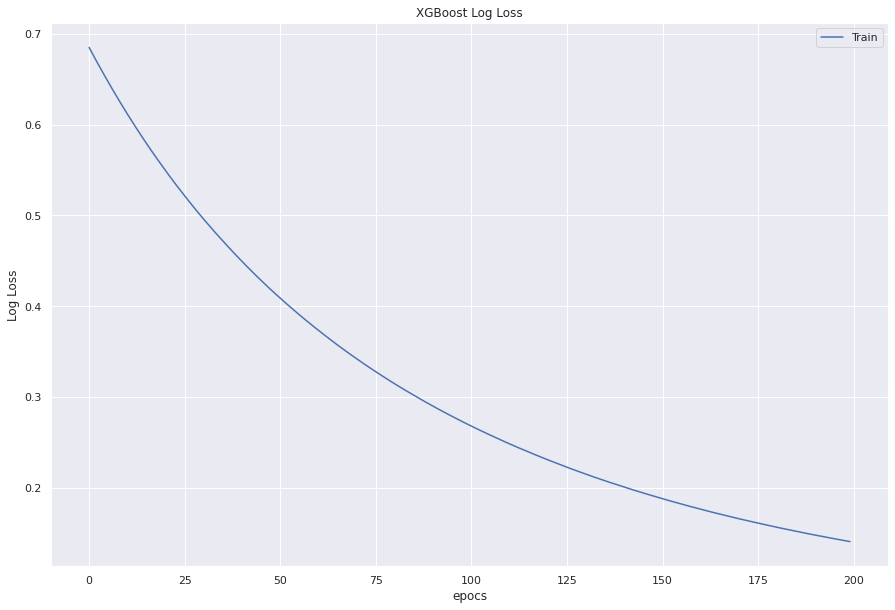

In [83]:
train_loses=np.mean([model.evals_result()['validation_0']['logloss'] for model in all_models],axis=0)
x_axis = range(0, len(train_loses))
# plot log loss
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x_axis, train_loses, label='Train');
ax.legend();
plt.ylabel('Log Loss');
plt.title('XGBoost Log Loss');
plt.xlabel('epocs');
plt.show();

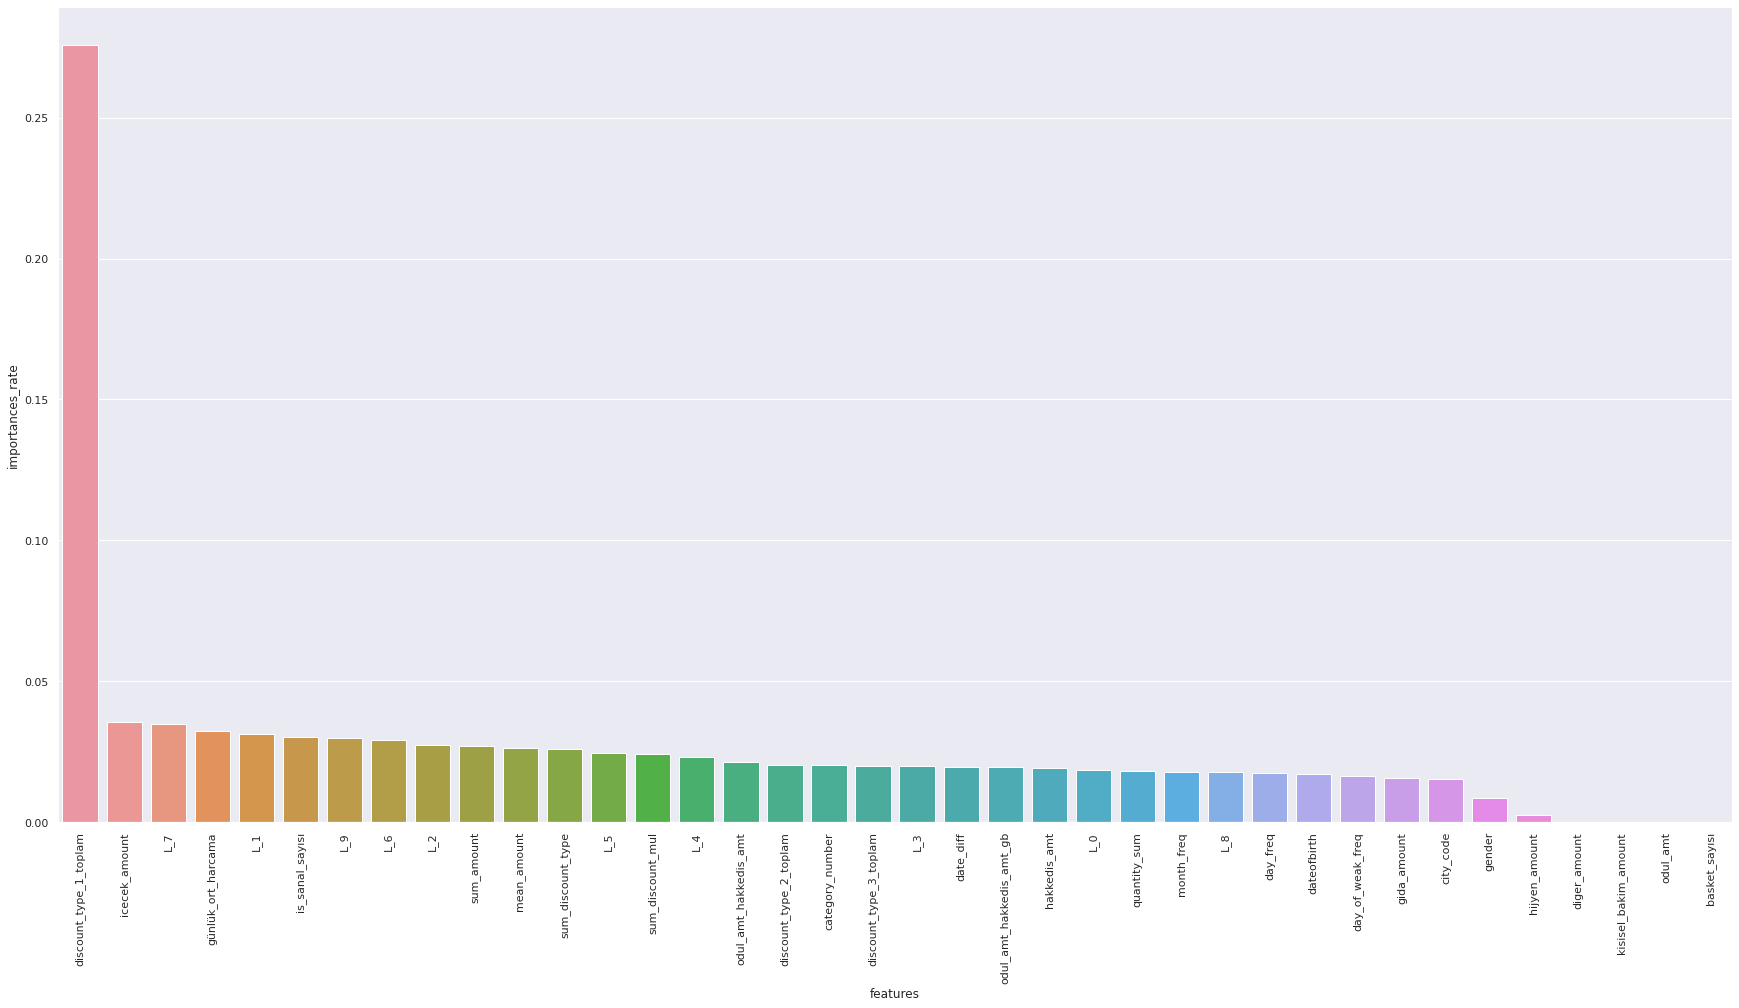

In [84]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [85]:
submission=test_id.to_frame()
submission['response']=pred
sample_submission=pd.read_csv('/kaggle/input/migros-datathon-coderspace/sample_submission.csv')
sample_submission=sample_submission[['individualnumber']].merge(submission,how='left',on='individualnumber').fillna(0)
sample_submission.response=sample_submission.response.astype(int)
sample_submission.set_index('individualnumber',drop=True,inplace=True)
sample_submission.to_csv('./migros_53.csv')

In [86]:
sample_submission

,response
individualnumber,
95812936,0
23929570,0
95948115,0
100898513,0
12769156,1
...,...
93418529,0
97397069,0
95212479,0


In [ ]:
ı have 